In [284]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader


import copy
import time
import os
import sys
import random

In [324]:
batch_size = 1024

In [325]:
# read the data from /input/train.csv
data = pd.read_csv("train.csv")

In [326]:
real_test_df = pd.read_csv('test.csv')

In [327]:
# split the data into train, validation and test sets
train_df, test_df = train_test_split(
    data, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(
    train_df, test_size=0.25, random_state=42)

In [328]:
train_df.shape

(70538, 10)

In [329]:
cols2use = train_df.columns.tolist()
cols2use.remove('id')
cols2use.remove('Class')

In [330]:
cols2use

['Mean_Integrated',
 'SD',
 'EK',
 'Skewness',
 'Mean_DMSNR_Curve',
 'SD_DMSNR_Curve',
 'EK_DMSNR_Curve',
 'Skewness_DMSNR_Curve']

In [331]:
class PulsarDataset(Dataset):

    def __init__(self, df, feature_columns=cols2use, with_labels=True):
        
        self.with_labels = with_labels
        self.ids = df.id.values
        
        #FEATURES
        self.features = df[feature_columns].values
        
        # LABELS
        if with_labels:
            self.labels = df.Class.values

    
    def __len__(self):
        return len(self.ids)
        
    def __getitem__(self, idx):

        ids = self.ids[idx]
        features = self.features[idx]
        
        targets = ''
        if self.with_labels:
            targets = self.labels[idx]
            sample = {'ids':ids,'features':features,'targets':targets}
        else:
            sample = {'ids':ids,'features':features}
       
        
        return sample

In [332]:
dataframes = {}

for phase in ['train', 'test', 'val', 'real_test']:
    dataframes[phase] = df=locals()[phase+'_df']

In [333]:
datasets = {}
dataloaders = {}
for split in ['train','val','test', 'real_test']: 
    shuffle = False
    with_labels = True
    if split=="train":
        shuffle = True
    if split=="real_test":
        with_labels = False
    datasets[split] =  PulsarDataset(df=dataframes[split], with_labels=with_labels)

    dataloaders[split] = DataLoader(datasets[split], batch_size=batch_size,
                              shuffle=shuffle)

In [334]:
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val','test', 'real_test']}
dataset_sizes

{'train': 70538, 'val': 23513, 'test': 23513, 'real_test': 78377}

In [335]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, l1_weight, l2_weight, optimizer, scheduler, num_epochs=1,model_filename=''):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100000000000000
    iters = []
    training_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        iters.append(epoch)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for output in dataloaders[phase]:
                features = output['features'].float()
                targets = output['targets']
                targets = torch.reshape(targets, (targets.size(0), 1))
                features = features.to(device)
                targets = targets.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                outputs = model(features)
            
                targets = torch.flatten(targets)
                
                loss = criterion(outputs, targets)
                loss = loss.to(device)
                
#                 l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
#                 l1_penalty = l1_penalty.to(device)
#                 l2_penalty = l2_weight * sum([(p**2).sum() for p in model.parameters()])
#                 l2_penalty = l2_penalty.to(device)
#                 loss += l1_penalty + l2_penalty
                
                if phase == 'train':
                    scheduler.step()
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * targets.size(0)
                
                


            epoch_loss = running_loss / dataset_sizes[phase]
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print('PASSED')
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Performance on test_set')
                eval_model(model,criterion, l1_weight, l2_weight, optimizer)
                if model_filename!='':
                    torch.save(model.state_dict(), os.path.join(model_filename))
                    
            if phase == 'train':
                training_losses.append(epoch_loss)
            elif phase == 'val':
                val_losses.append(epoch_loss)

        plt.plot(iters, training_losses, label='training loss')
        plt.plot(iters, val_losses, label='validation loss')
        plt.xlabel("Epoch")
        plt.ylabel("Losses")
        plt.legend(loc='best')
        plt.show()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [336]:
def eval_model(model, criterion, l1_weight, l2_weight, optimizer):
    since = time.time()
    phase = 'test'
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0

    
    # Iterate over data.
    predictions = []
    tars = []
    for output in dataloaders[phase]:
        features = output['features'].float()
        targets = output['targets']
        targets = torch.reshape(targets, (targets.size(0), 1))
        features = features.to(device)
        targets = targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()



        with torch.no_grad():
            outputs = model(features)


            targets = torch.flatten(targets)
            loss = criterion(outputs, targets)
            loss = loss.to(device)            
            
#             l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
#             l1_penalty = l1_penalty.to(device)
#             l2_penalty = l2_weight * sum([(p**2).sum() for p in model.parameters()])
#             l2_penalty = l2_penalty.to(device)
#             loss += l1_penalty + l2_penalty
            
        # statistics
        running_loss += loss.item() * targets.size(0)
        

    eval_loss = running_loss / dataset_sizes[phase]

    
    time_elapsed = time.time() - since
    print('Evaluation Loss: {:.4f}'.format(eval_loss))
    
    return eval_loss

In [337]:
def predict(model, criterion, l1_weight, l2_weight, optimizer, phase):
    
    since = time.time()
    model.eval()   # Set model to evaluate mode
    
    # Iterate over data.
    
    count =0
    

    names = []
    predictions = []
    tars = []

    for output in dataloaders[phase]:
        ids = output['ids']
        features = output['features'].float()
        features = features.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()



        with torch.no_grad():
            outputs = model(features)
            
            outputs =  outputs.squeeze()
            outputs.size()
            
            if count == 0:

                predictions = np.array([np.array(outputs[:,0]), np.array(outputs[:,1]), np.array(ids)])
            else:
                predictions = np.append(predictions, [np.array(outputs[:,0]), np.array(outputs[:,1]), np.array(ids)], axis=1)
            count += 1

    time_elapsed = time.time() - since
    
    # transpose predictions
    preds = predictions.transpose(1,0)

    # get unnormalized probabilities
    unnormalized_probs = preds[:,0:2]

    # normalize probabilities
    SM = nn.Softmax(dim=1)
    normalized_probs = np.array(SM(torch.tensor(unnormalized_probs)).detach().numpy())

    # make a dataframe with the unnormalized probabilities and the preds
    preds = preds[:,2]
    pred_df = pd.DataFrame(np.concatenate((preds.reshape(-1,1), normalized_probs), axis=1), columns=['id', 'prob_1', 'prob_2'])

    # drop one of the probabilities
    pred_df.drop('prob_1', axis=1, inplace=True)

    # rename the other probability column
    pred_df.rename(columns={'prob_2': 'Class'}, inplace=True)

    # convert the id column to int
    pred_df['id'] = pred_df['id'].astype(int)

    #pred_df = pd.DataFrame(predictions.transpose(1,0), columns=['prob_1', 'prob_2', 'ids'])
    return pred_df


In [338]:
class myModel(nn.Module):
    
    def __init__(self, num_nodes=100):
        super(myModel, self).__init__()
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        
        self.final = torch.nn.Sequential(
        torch.nn.Linear(8, 256, bias = False),
        torch.nn.BatchNorm1d(256),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.2, inplace=False),
        torch.nn.Linear(256, 128, bias = False),
        torch.nn.BatchNorm1d(128),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.2, inplace=False),
        torch.nn.Linear(128, 64, bias = True),
        torch.nn.BatchNorm1d(64),
        torch.nn.ReLU(),
        # #torch.nn.Dropout(p=0.3, inplace=False),
        # #torch.nn.Linear(128, 64, bias = False),
        # #torch.nn.ReLU(),
        # #torch.nn.BatchNorm1d(num_nodes),
        # #torch.nn.Linear(64, 1, bias=True)
        # #torch.nn.ReLU(),
        torch.nn.Linear(64, 2, bias=True),
        # torch.nn.Softmax()
        )

        
    def forward(self, features):
        all_features = features
        final_out = self.final(all_features)
        return final_out

In [339]:
model = myModel(64)

In [340]:
criterion = torch.nn.CrossEntropyLoss()

In [341]:
# Observe that all parameters are being optimized

#optimizer = torch.optim.SGD(model.parameters(), lr=0.0000008, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters())
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

l1_weight = 0e-4
l2_weight = 0e-4

In [342]:
# one cycle LR

epochs = 150

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(dataloaders['train']), three_phase = False, epochs=epochs)

----------
Epoch 1/150


c:\Users\berkidem\.conda\envs\DeepLearningEnv\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.2137
val Loss: 0.1062
PASSED
Performance on test_set
Evaluation Loss: 0.1054


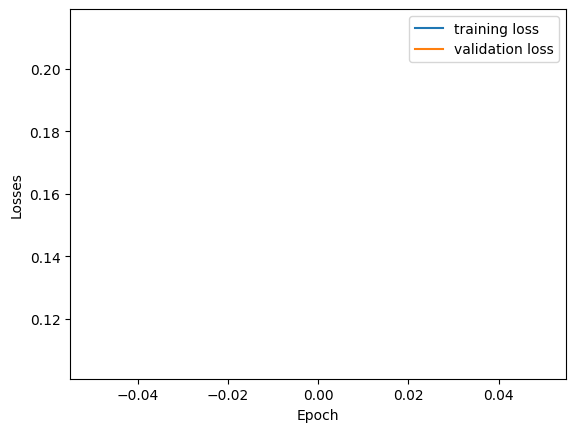

----------
Epoch 2/150
train Loss: 0.0822
val Loss: 0.0638
PASSED
Performance on test_set
Evaluation Loss: 0.0632


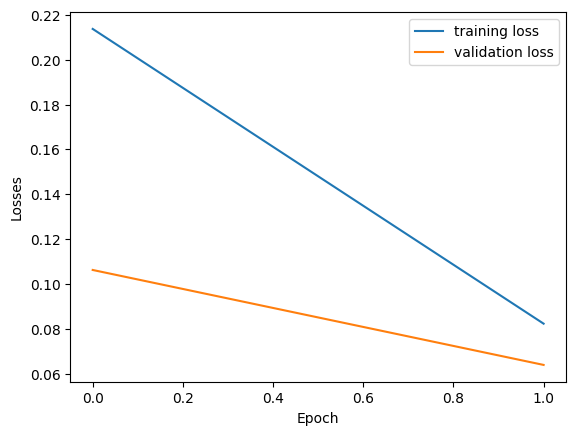

----------
Epoch 3/150
train Loss: 0.0595
val Loss: 0.0526
PASSED
Performance on test_set
Evaluation Loss: 0.0523


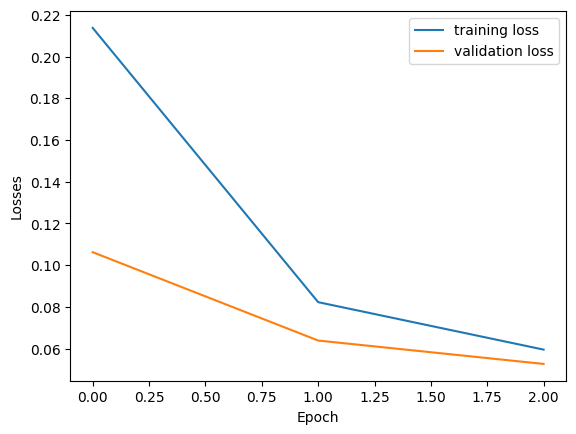

----------
Epoch 4/150
train Loss: 0.0515
val Loss: 0.0459
PASSED
Performance on test_set
Evaluation Loss: 0.0461


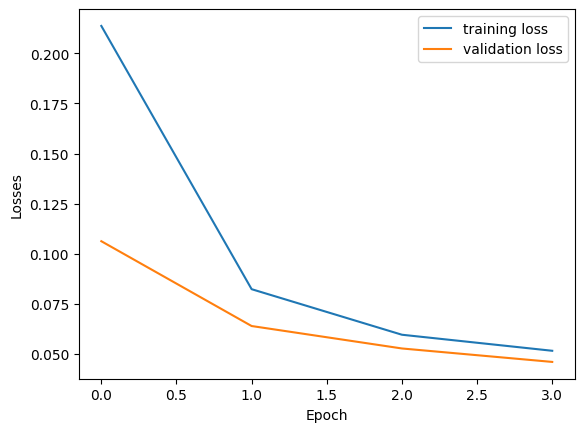

----------
Epoch 5/150
train Loss: 0.0481
val Loss: 0.0426
PASSED
Performance on test_set
Evaluation Loss: 0.0429


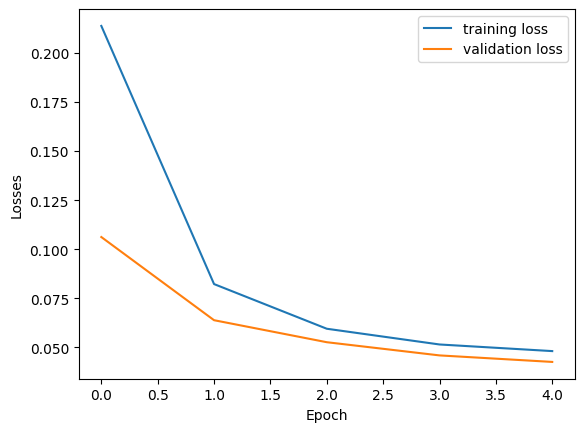

----------
Epoch 6/150
train Loss: 0.0451
val Loss: 0.0414
PASSED
Performance on test_set
Evaluation Loss: 0.0420


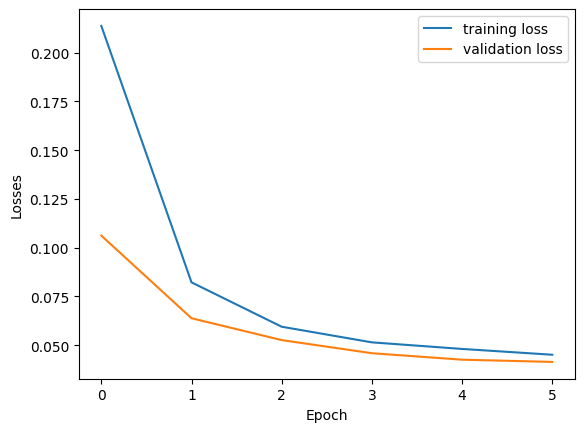

----------
Epoch 7/150
train Loss: 0.0436
val Loss: 0.0400
PASSED
Performance on test_set
Evaluation Loss: 0.0405


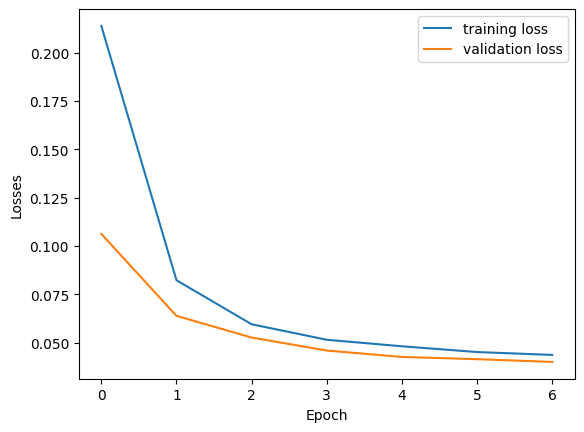

----------
Epoch 8/150
train Loss: 0.0422
val Loss: 0.0384
PASSED
Performance on test_set
Evaluation Loss: 0.0397


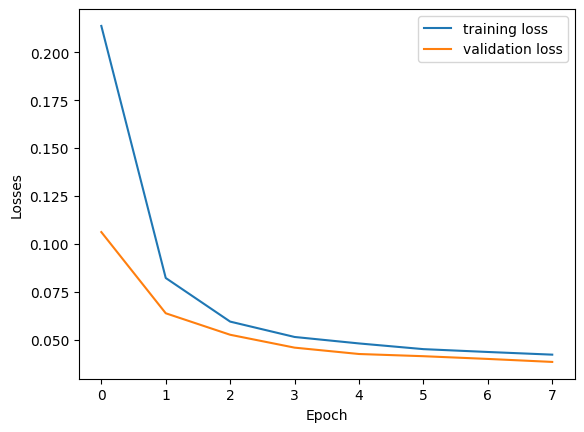

----------
Epoch 9/150
train Loss: 0.0425
val Loss: 0.0380
PASSED
Performance on test_set
Evaluation Loss: 0.0396


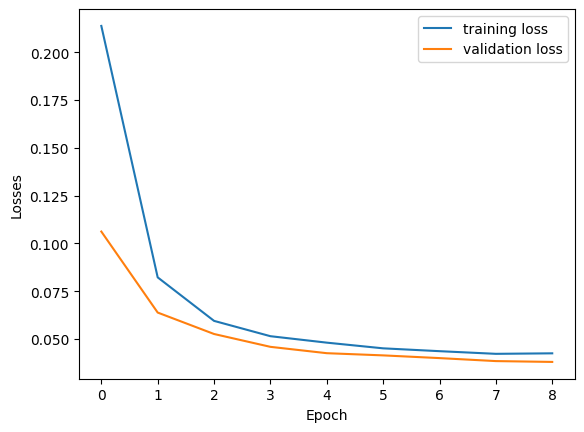

----------
Epoch 10/150
train Loss: 0.0410
val Loss: 0.0376
PASSED
Performance on test_set
Evaluation Loss: 0.0387


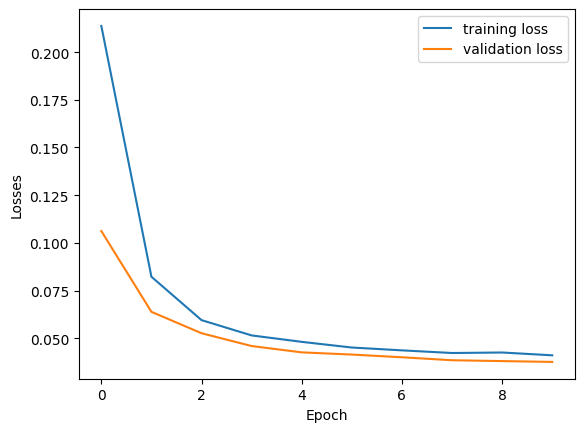

----------
Epoch 11/150
train Loss: 0.0397
val Loss: 0.0362
PASSED
Performance on test_set
Evaluation Loss: 0.0381


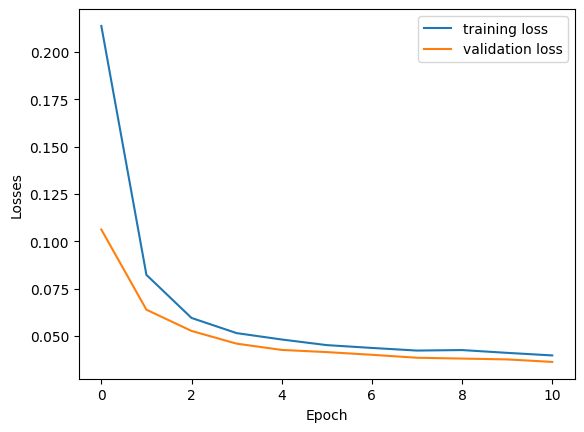

----------
Epoch 12/150
train Loss: 0.0408
val Loss: 0.0373


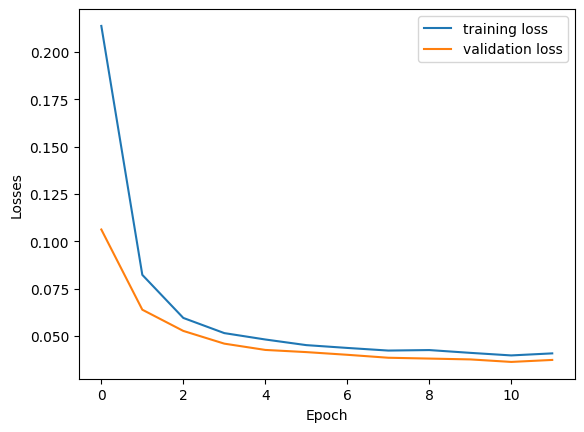

----------
Epoch 13/150
train Loss: 0.0394
val Loss: 0.0352
PASSED
Performance on test_set
Evaluation Loss: 0.0369


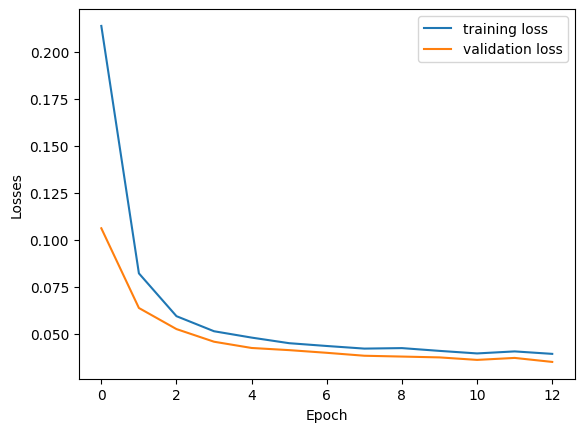

----------
Epoch 14/150
train Loss: 0.0390
val Loss: 0.0342
PASSED
Performance on test_set
Evaluation Loss: 0.0365


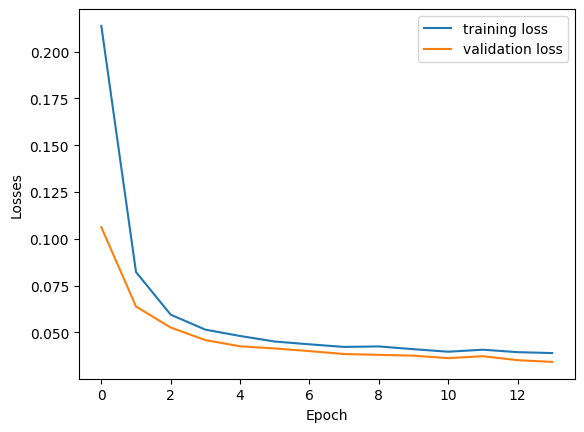

----------
Epoch 15/150
train Loss: 0.0391
val Loss: 0.0342
PASSED
Performance on test_set
Evaluation Loss: 0.0354


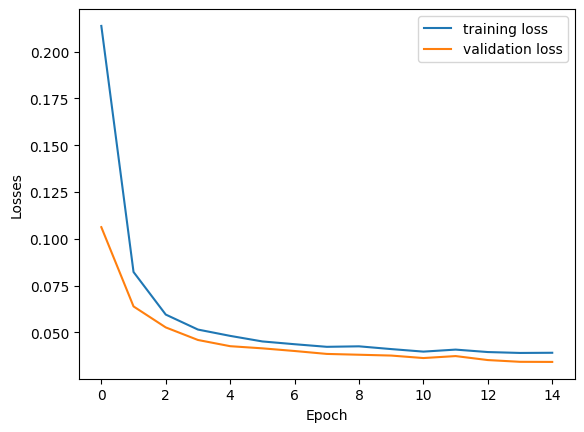

----------
Epoch 16/150
train Loss: 0.0384
val Loss: 0.0355


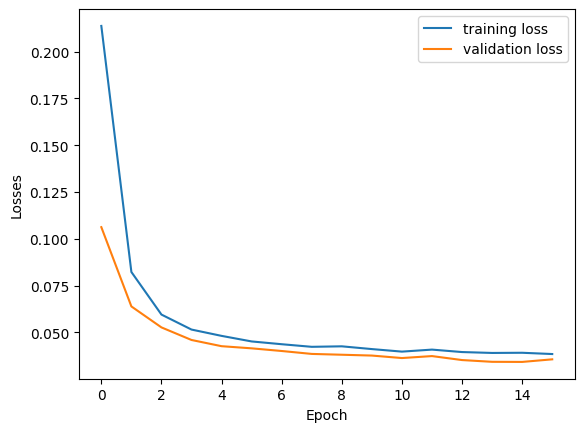

----------
Epoch 17/150
train Loss: 0.0377
val Loss: 0.0335
PASSED
Performance on test_set
Evaluation Loss: 0.0366


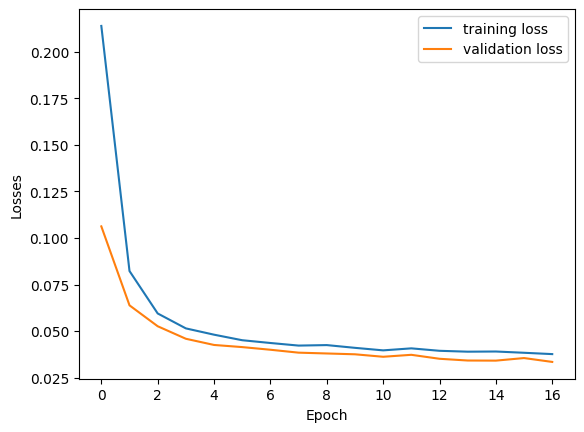

----------
Epoch 18/150
train Loss: 0.0371
val Loss: 0.0336


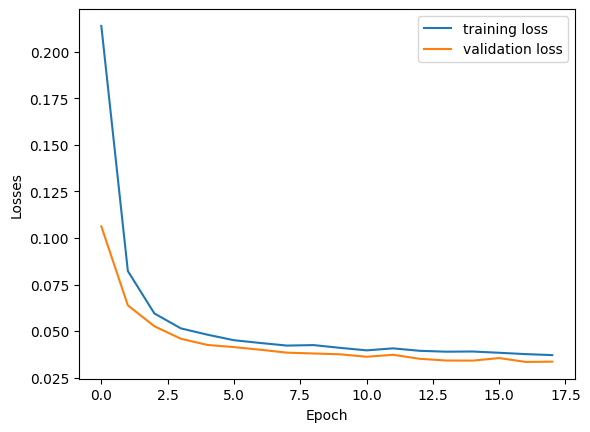

----------
Epoch 19/150
train Loss: 0.0368
val Loss: 0.0328
PASSED
Performance on test_set
Evaluation Loss: 0.0355


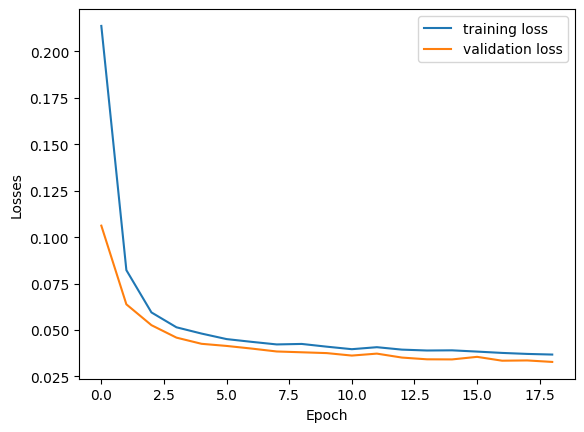

----------
Epoch 20/150
train Loss: 0.0372
val Loss: 0.0348


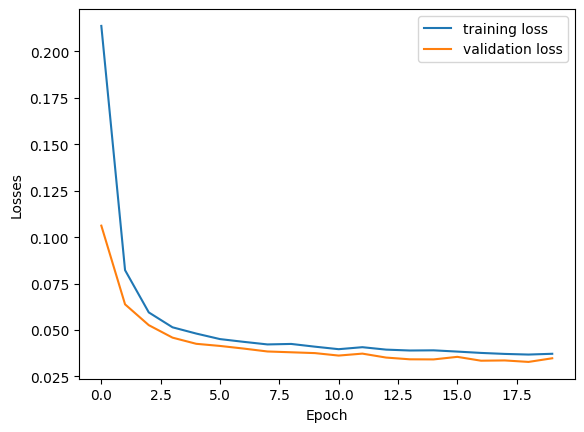

----------
Epoch 21/150
train Loss: 0.0364
val Loss: 0.0330


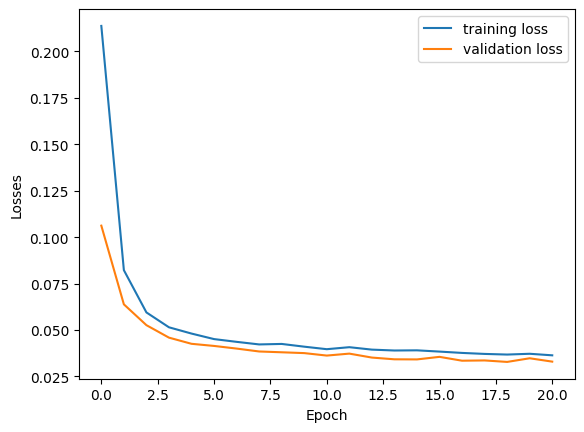

----------
Epoch 22/150
train Loss: 0.0369
val Loss: 0.0323
PASSED
Performance on test_set
Evaluation Loss: 0.0353


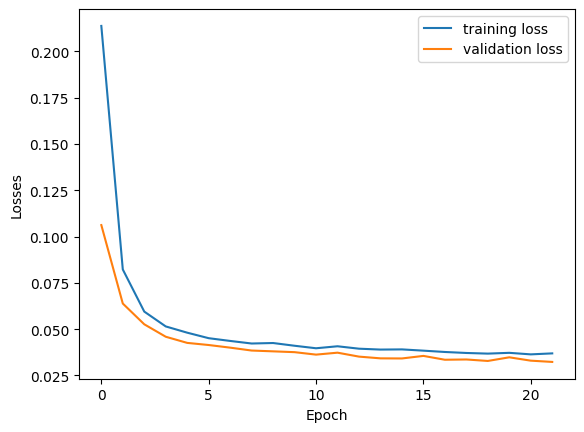

----------
Epoch 23/150
train Loss: 0.0368
val Loss: 0.0383


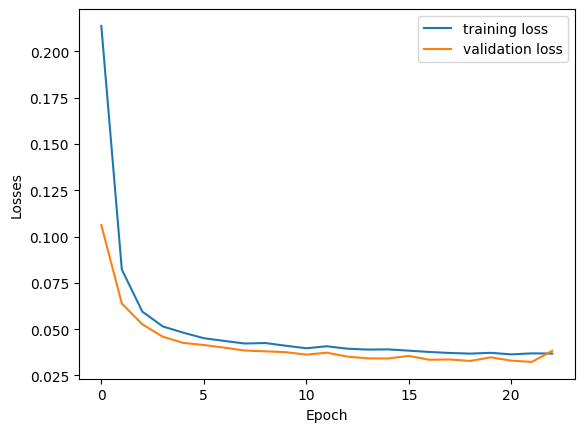

----------
Epoch 24/150
train Loss: 0.0365
val Loss: 0.0341


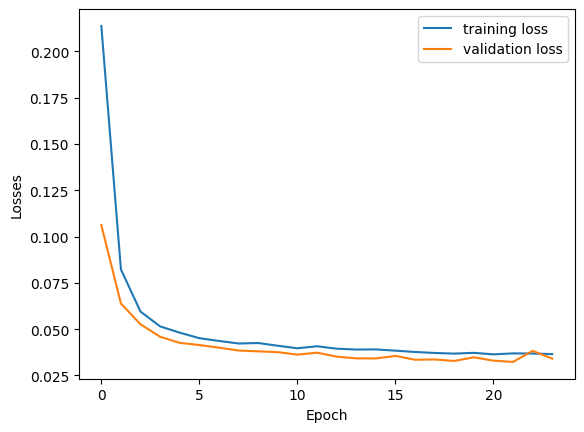

----------
Epoch 25/150
train Loss: 0.0369
val Loss: 0.0343


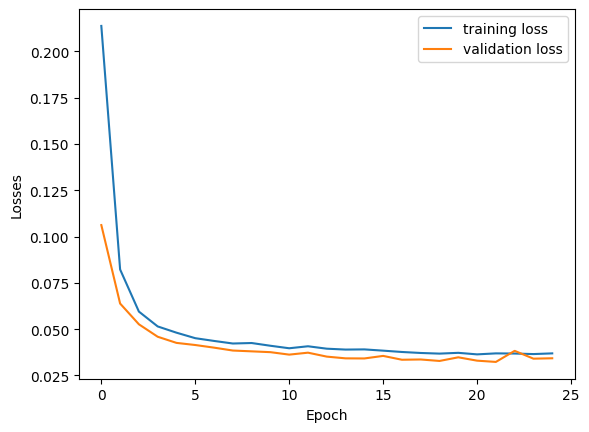

----------
Epoch 26/150
train Loss: 0.0367
val Loss: 0.0319
PASSED
Performance on test_set
Evaluation Loss: 0.0340


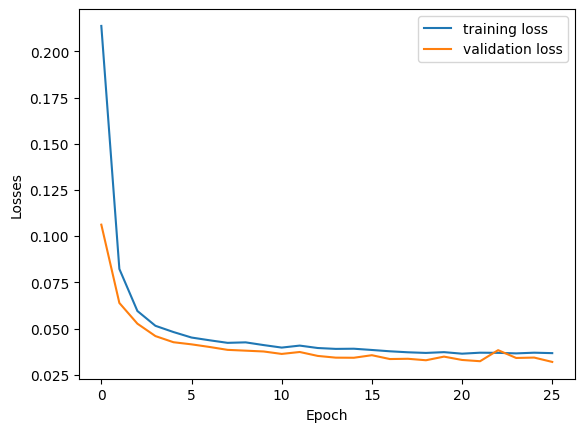

----------
Epoch 27/150
train Loss: 0.0356
val Loss: 0.0331


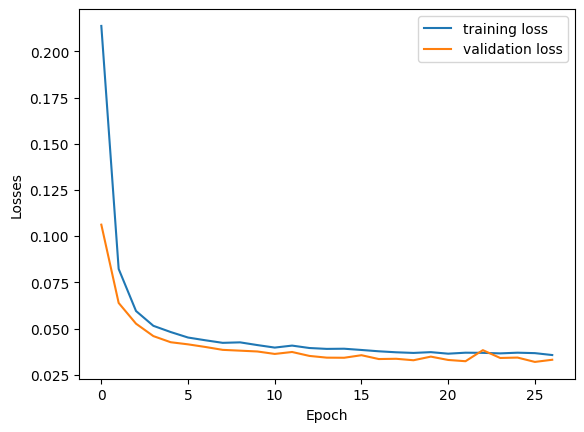

----------
Epoch 28/150
train Loss: 0.0361
val Loss: 0.0342


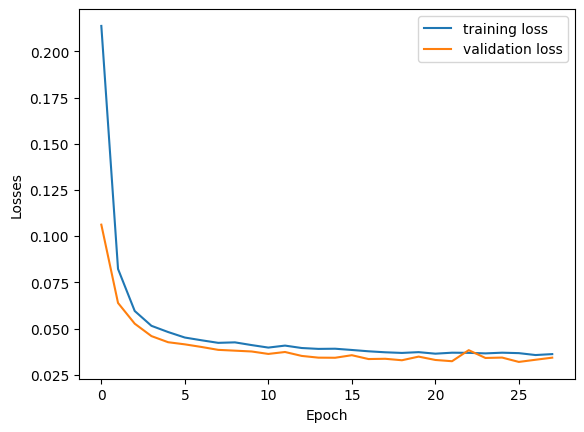

----------
Epoch 29/150
train Loss: 0.0368
val Loss: 0.0329


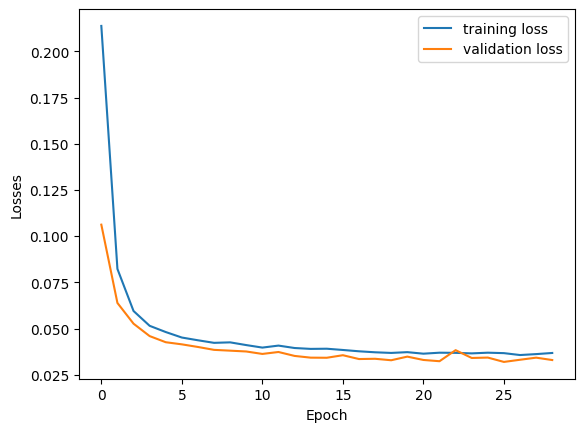

----------
Epoch 30/150
train Loss: 0.0356
val Loss: 0.0335


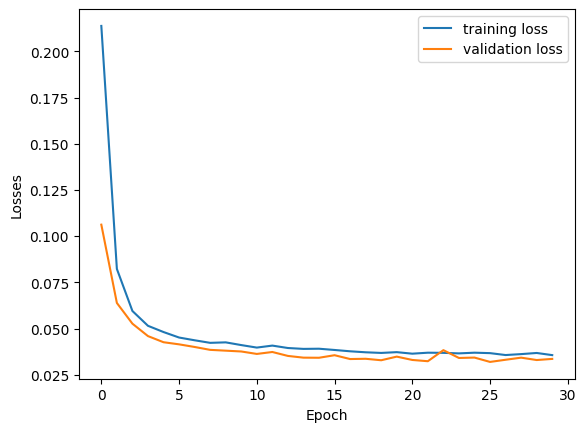

----------
Epoch 31/150
train Loss: 0.0352
val Loss: 0.0345


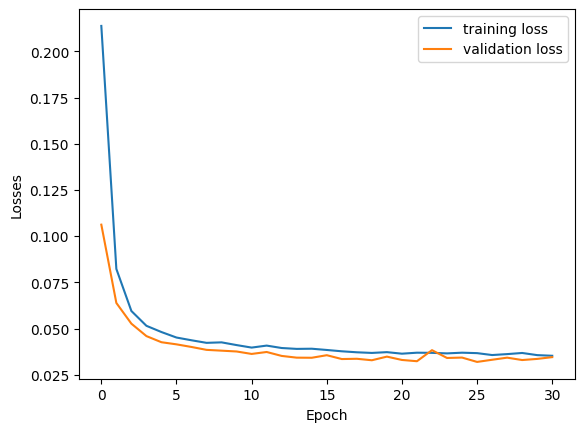

----------
Epoch 32/150
train Loss: 0.0359
val Loss: 0.0323


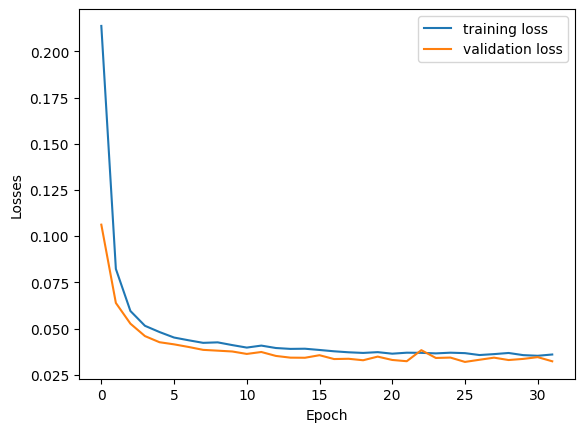

----------
Epoch 33/150
train Loss: 0.0357
val Loss: 0.0471


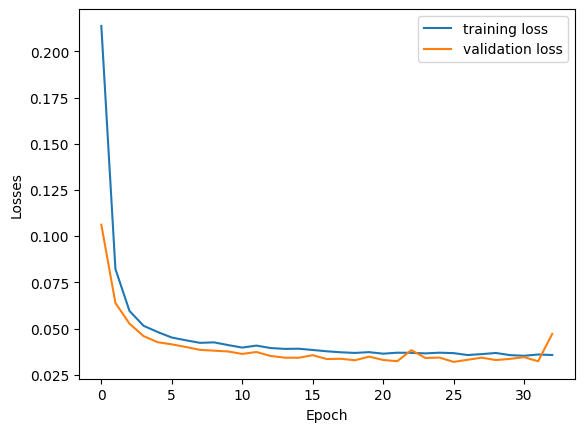

----------
Epoch 34/150
train Loss: 0.0351
val Loss: 0.0327


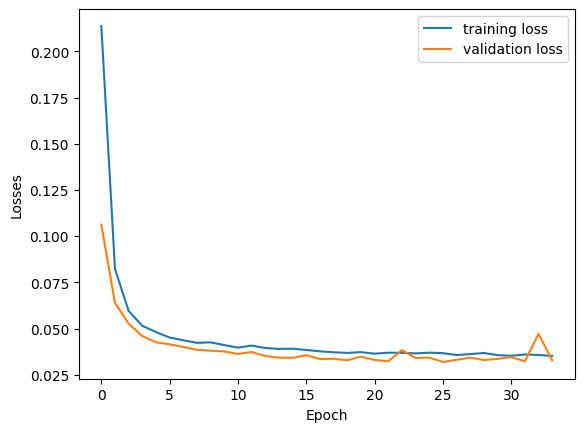

----------
Epoch 35/150
train Loss: 0.0360
val Loss: 0.0340


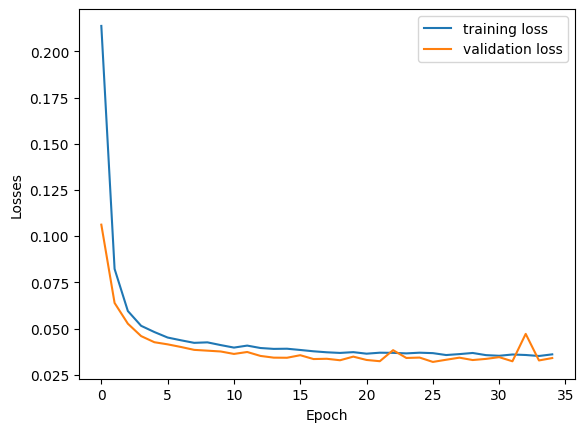

----------
Epoch 36/150
train Loss: 0.0354
val Loss: 0.0337


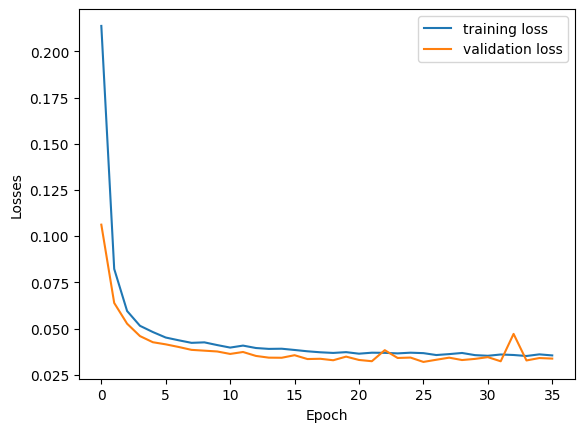

----------
Epoch 37/150
train Loss: 0.0347
val Loss: 0.0327


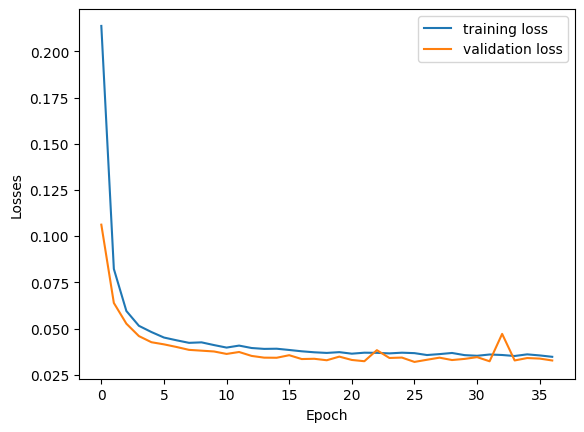

----------
Epoch 38/150
train Loss: 0.0348
val Loss: 0.0322


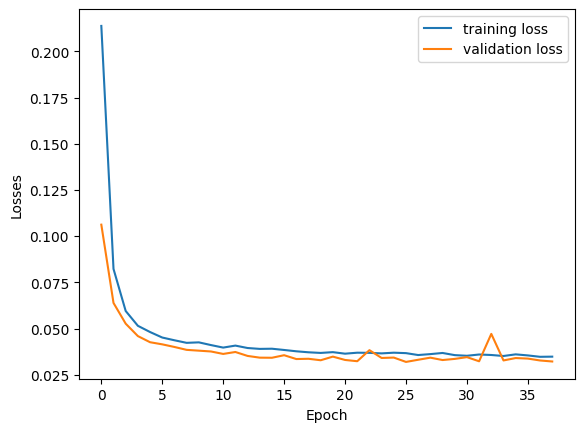

----------
Epoch 39/150
train Loss: 0.0353
val Loss: 0.0331


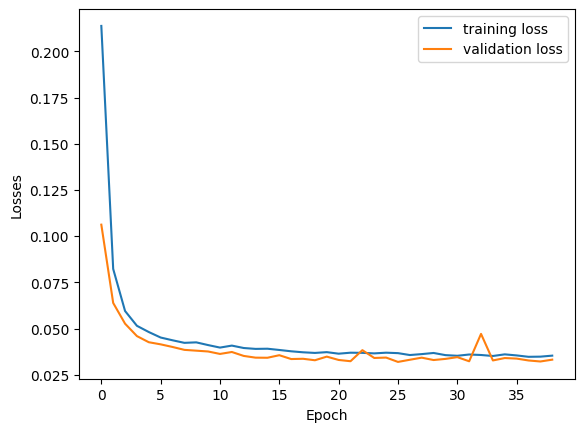

----------
Epoch 40/150
train Loss: 0.0363
val Loss: 0.0369


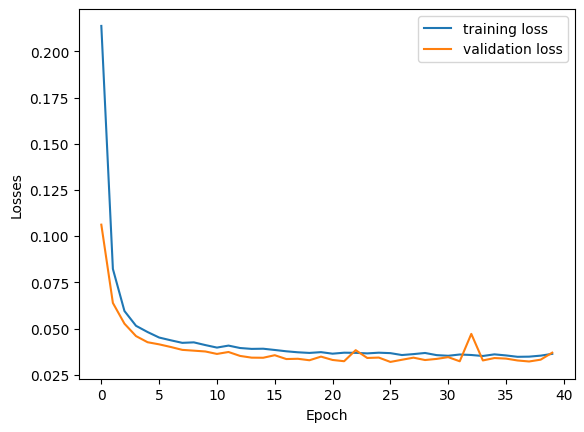

----------
Epoch 41/150
train Loss: 0.0351
val Loss: 0.0330


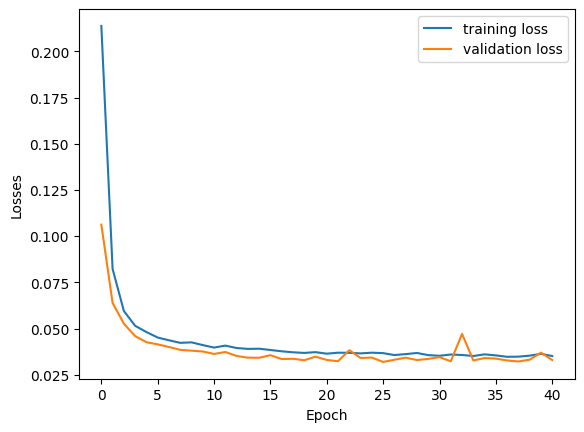

----------
Epoch 42/150
train Loss: 0.0349
val Loss: 0.0355


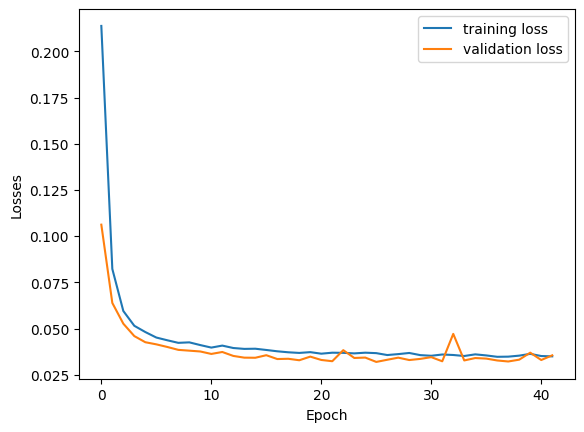

----------
Epoch 43/150
train Loss: 0.0351
val Loss: 0.0321


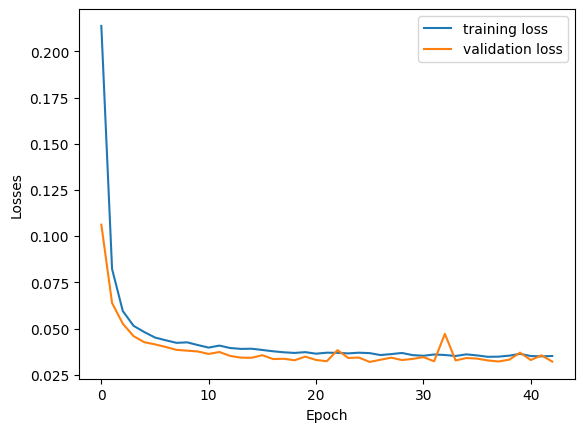

----------
Epoch 44/150
train Loss: 0.0352
val Loss: 0.0355


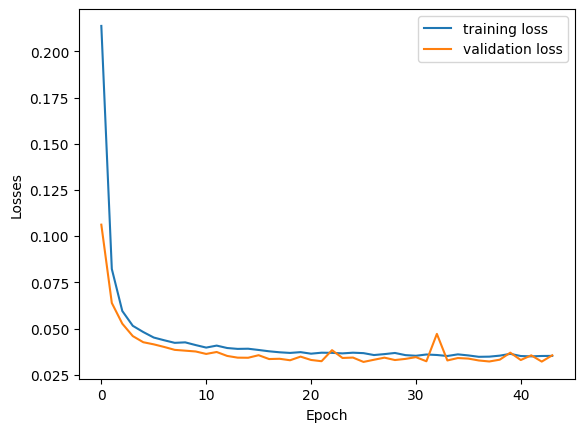

----------
Epoch 45/150
train Loss: 0.0341
val Loss: 0.0336


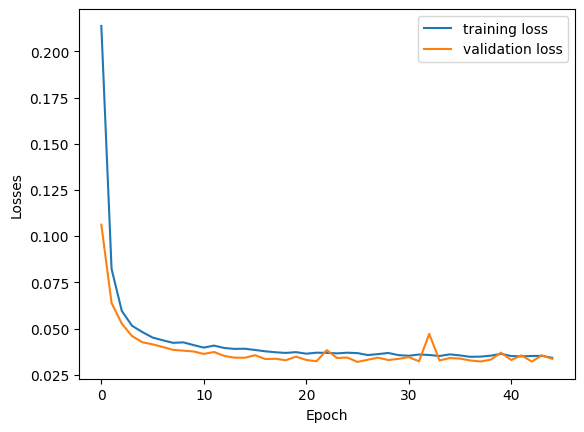

----------
Epoch 46/150
train Loss: 0.0345
val Loss: 0.0341


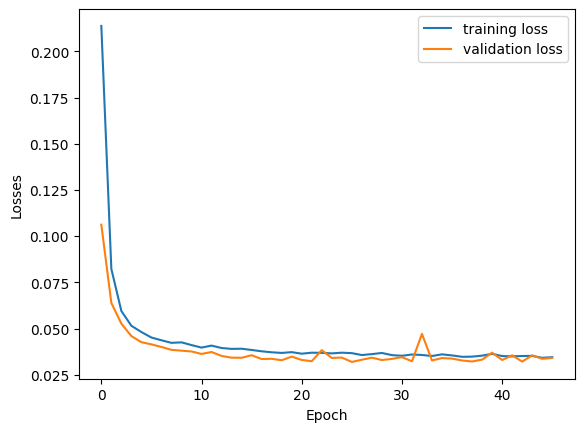

----------
Epoch 47/150
train Loss: 0.0347
val Loss: 0.0316
PASSED
Performance on test_set
Evaluation Loss: 0.0342


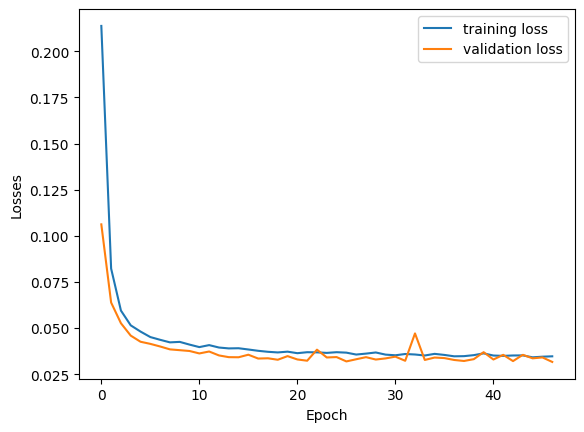

----------
Epoch 48/150
train Loss: 0.0352
val Loss: 0.0329


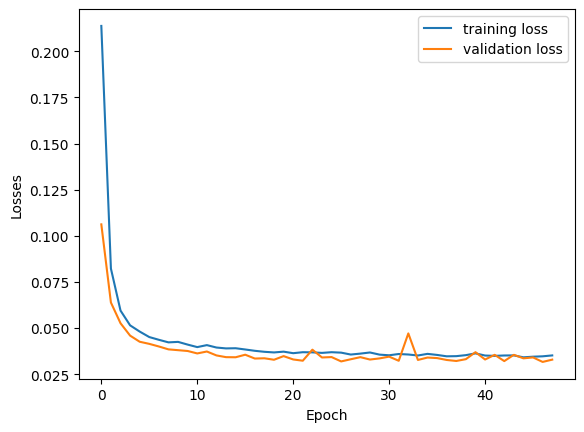

----------
Epoch 49/150
train Loss: 0.0348
val Loss: 0.0337


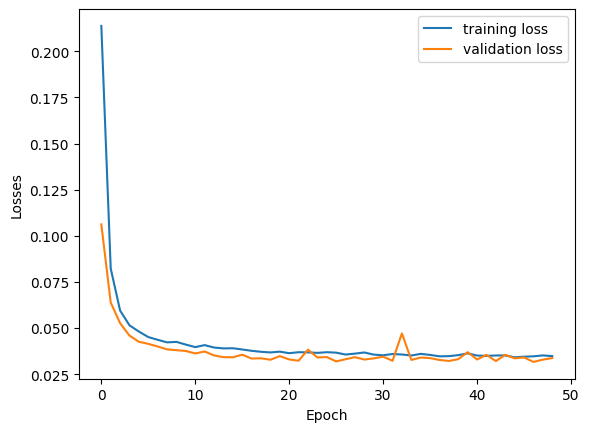

----------
Epoch 50/150
train Loss: 0.0344
val Loss: 0.0342


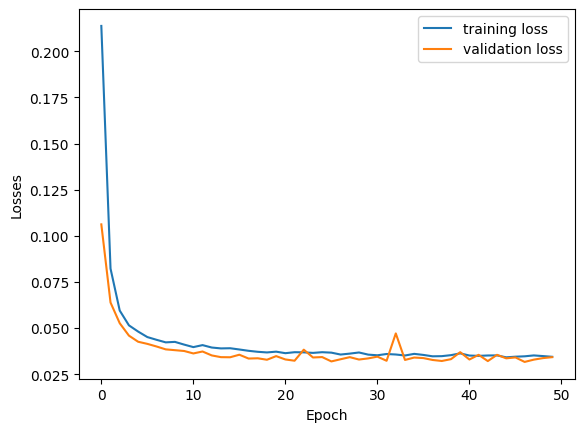

----------
Epoch 51/150
train Loss: 0.0341
val Loss: 0.0321


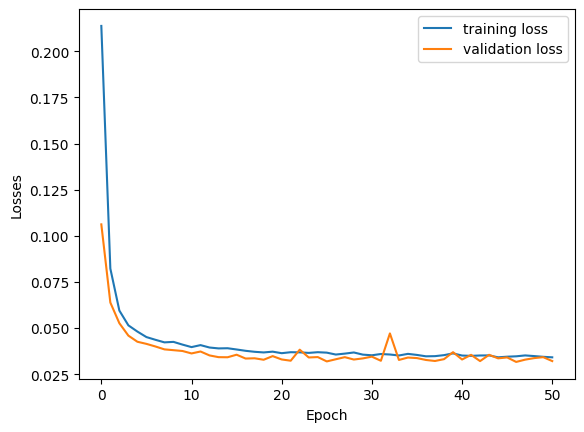

----------
Epoch 52/150
train Loss: 0.0339
val Loss: 0.0327


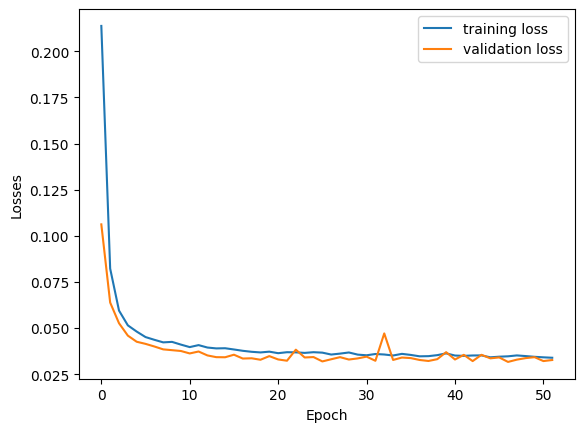

----------
Epoch 53/150
train Loss: 0.0345
val Loss: 0.0328


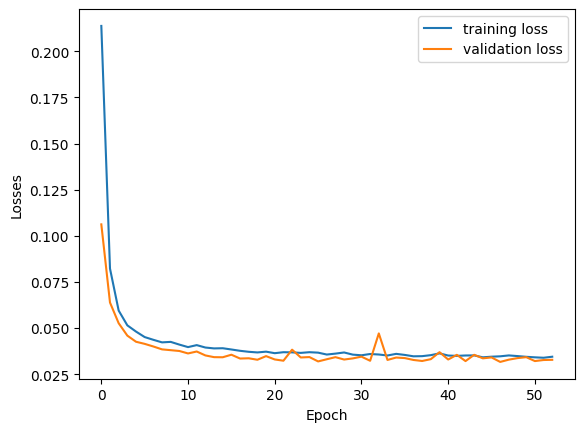

----------
Epoch 54/150
train Loss: 0.0345
val Loss: 0.0323


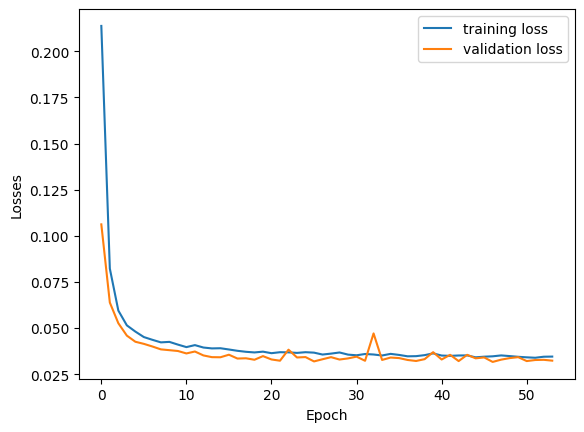

----------
Epoch 55/150
train Loss: 0.0341
val Loss: 0.0318


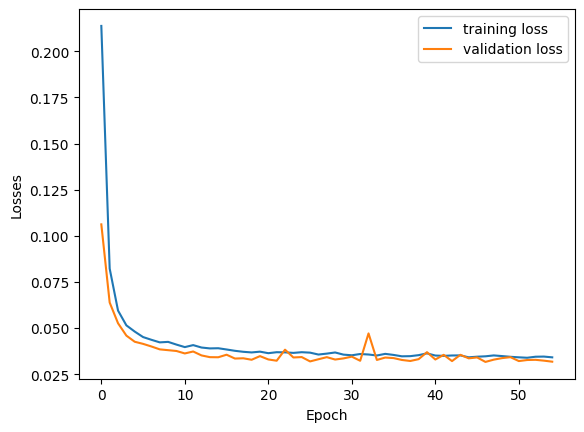

----------
Epoch 56/150
train Loss: 0.0342
val Loss: 0.0333


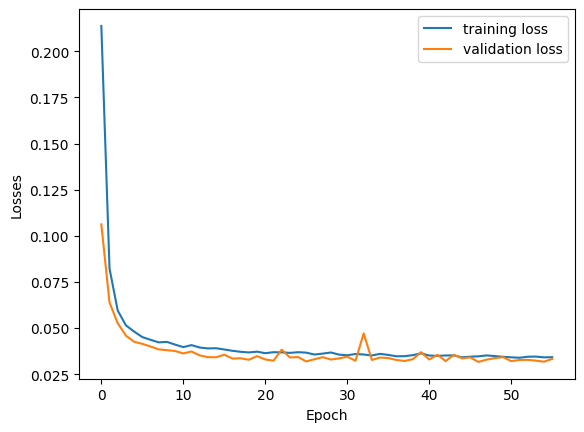

----------
Epoch 57/150
train Loss: 0.0341
val Loss: 0.0317


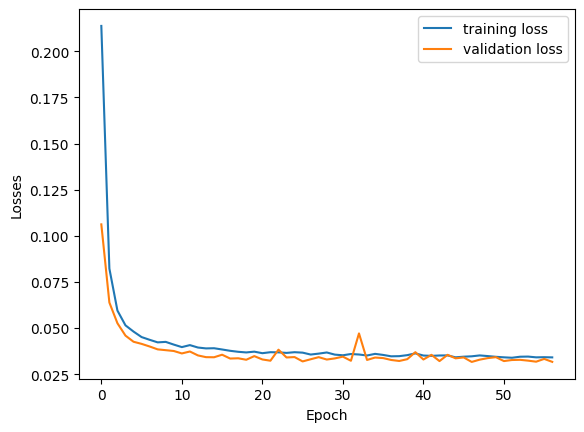

----------
Epoch 58/150
train Loss: 0.0339
val Loss: 0.0313
PASSED
Performance on test_set
Evaluation Loss: 0.0337


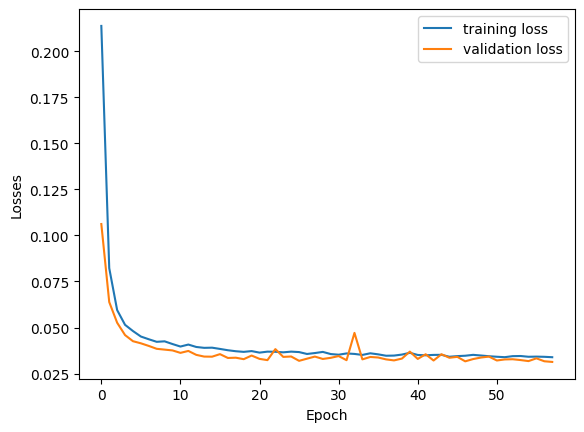

----------
Epoch 59/150
train Loss: 0.0343
val Loss: 0.0370


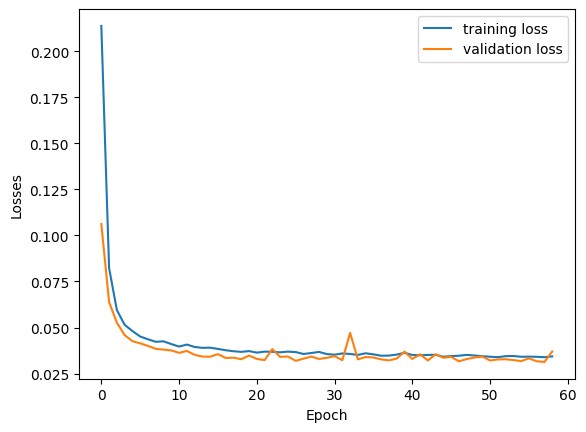

----------
Epoch 60/150
train Loss: 0.0337
val Loss: 0.0357


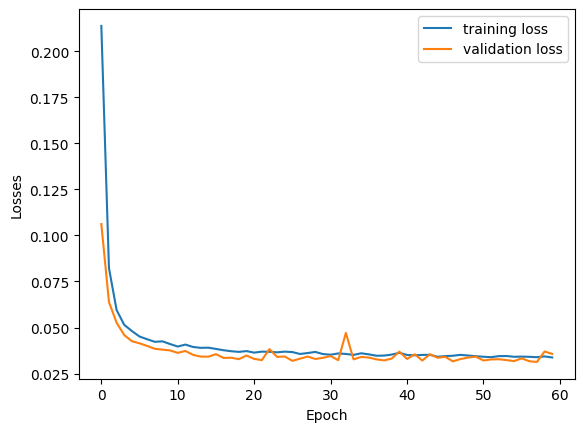

----------
Epoch 61/150
train Loss: 0.0338
val Loss: 0.0329


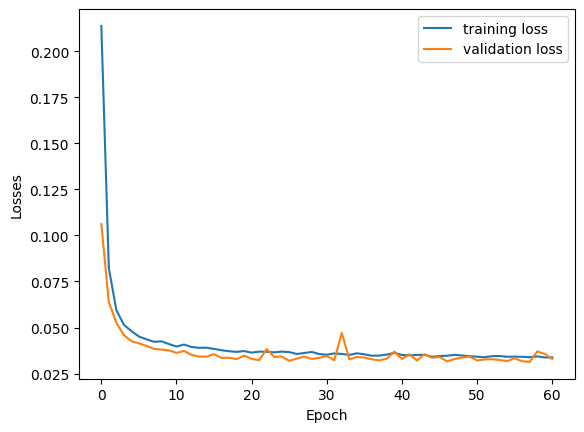

----------
Epoch 62/150
train Loss: 0.0336
val Loss: 0.0310
PASSED
Performance on test_set
Evaluation Loss: 0.0336


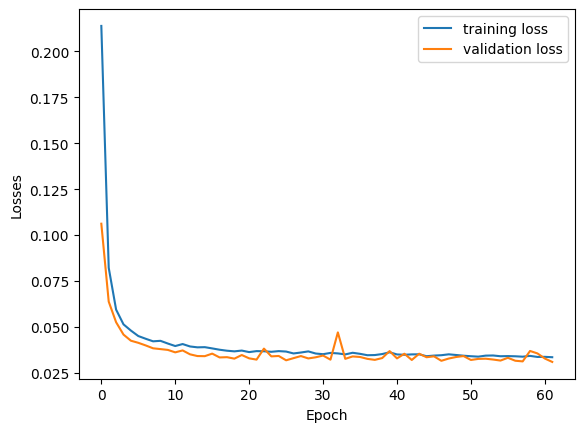

----------
Epoch 63/150
train Loss: 0.0338
val Loss: 0.0328


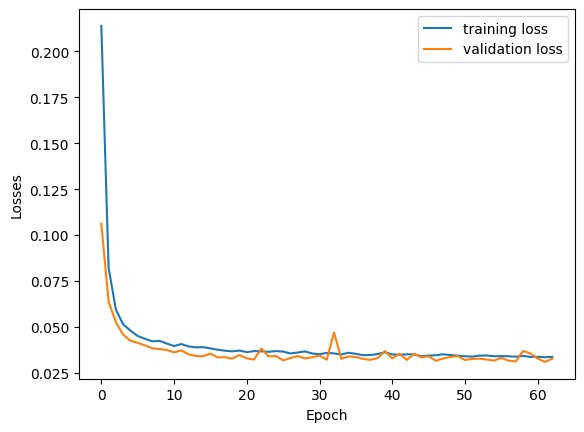

----------
Epoch 64/150
train Loss: 0.0338
val Loss: 0.0319


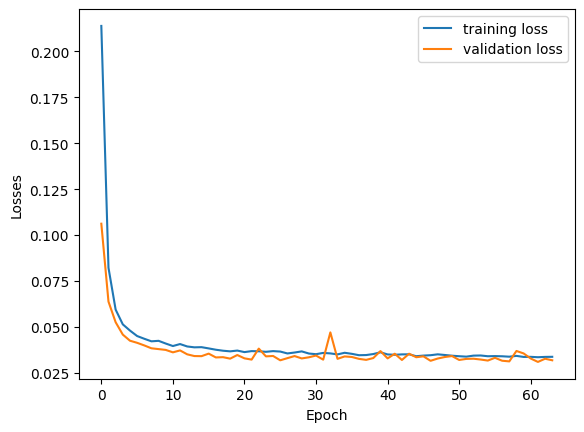

----------
Epoch 65/150
train Loss: 0.0333
val Loss: 0.0311


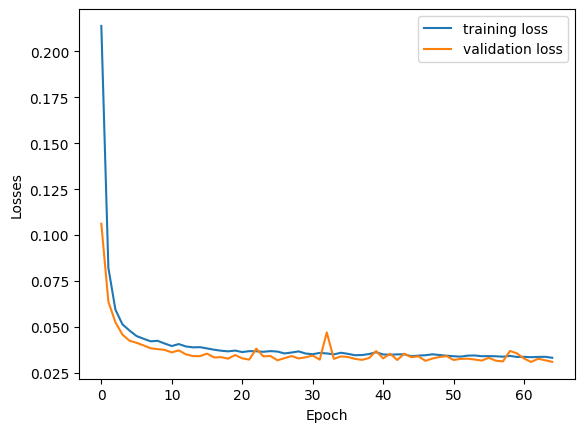

----------
Epoch 66/150
train Loss: 0.0332
val Loss: 0.0322


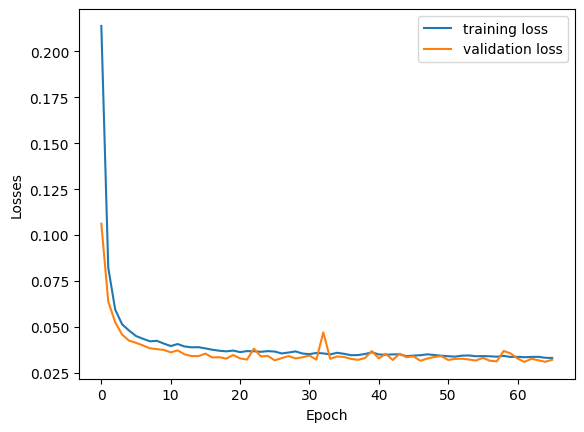

----------
Epoch 67/150
train Loss: 0.0332
val Loss: 0.0324


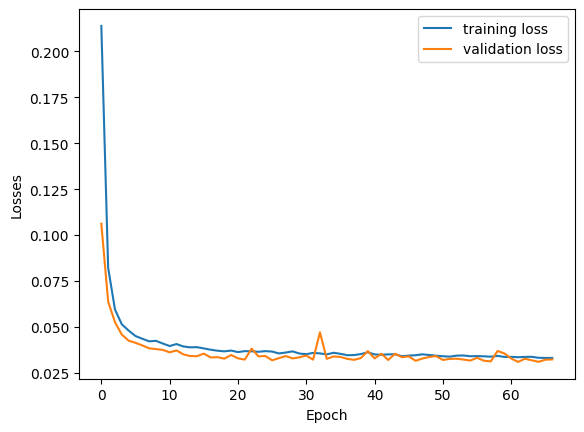

----------
Epoch 68/150
train Loss: 0.0334
val Loss: 0.0314


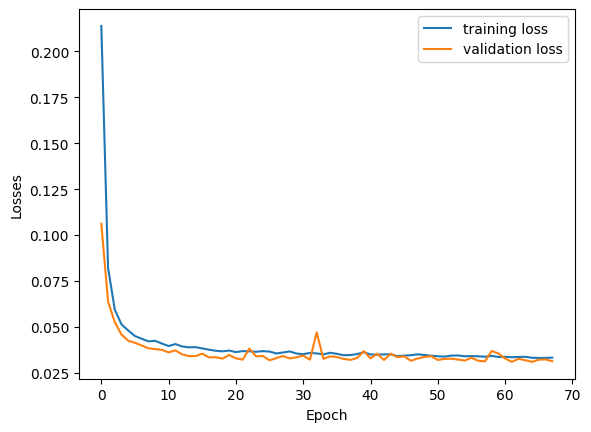

----------
Epoch 69/150
train Loss: 0.0330
val Loss: 0.0307
PASSED
Performance on test_set
Evaluation Loss: 0.0339


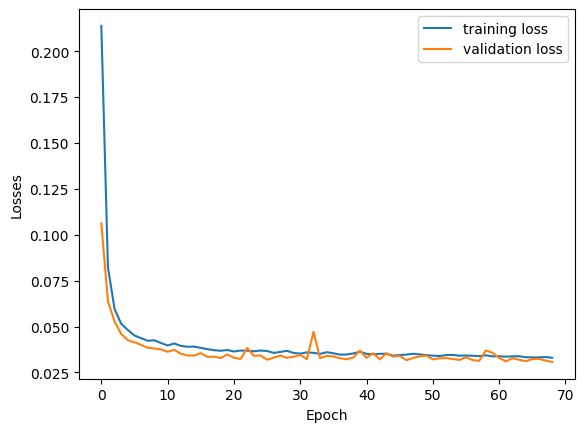

----------
Epoch 70/150
train Loss: 0.0332
val Loss: 0.0324


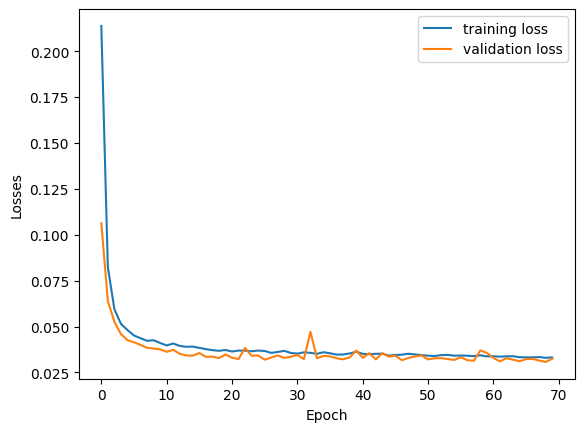

----------
Epoch 71/150
train Loss: 0.0334
val Loss: 0.0313


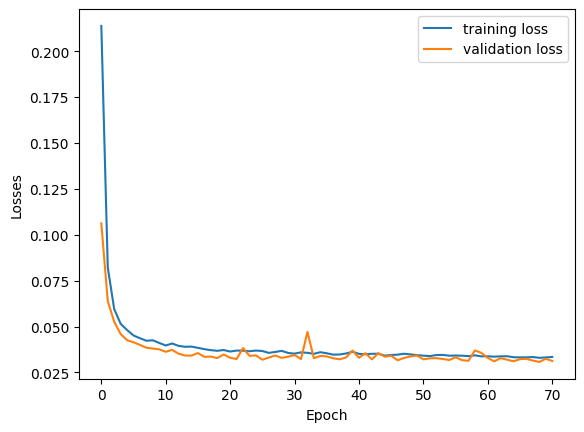

----------
Epoch 72/150
train Loss: 0.0330
val Loss: 0.0313


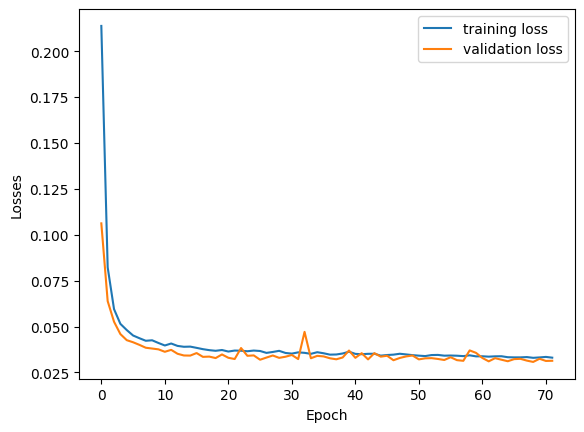

----------
Epoch 73/150
train Loss: 0.0331
val Loss: 0.0322


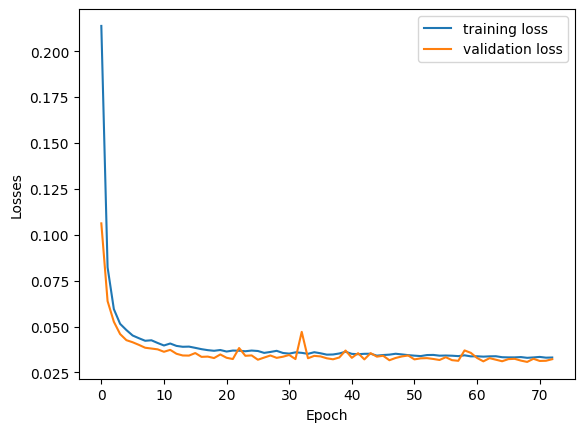

----------
Epoch 74/150
train Loss: 0.0330
val Loss: 0.0309


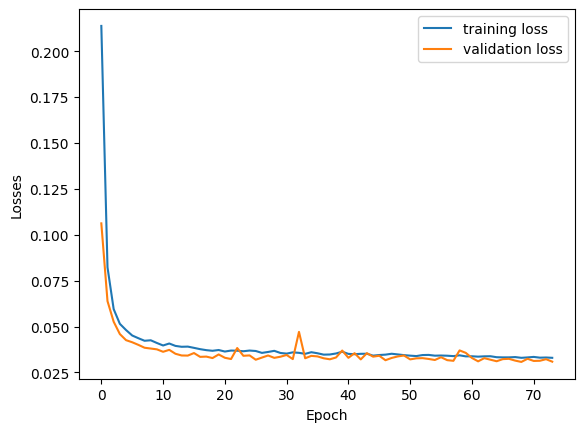

----------
Epoch 75/150
train Loss: 0.0335
val Loss: 0.0323


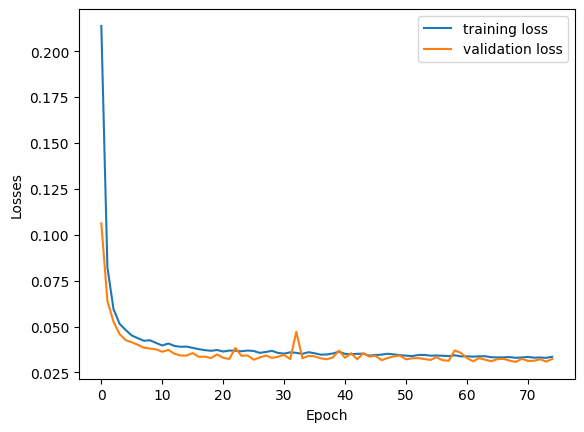

----------
Epoch 76/150
train Loss: 0.0334
val Loss: 0.0310


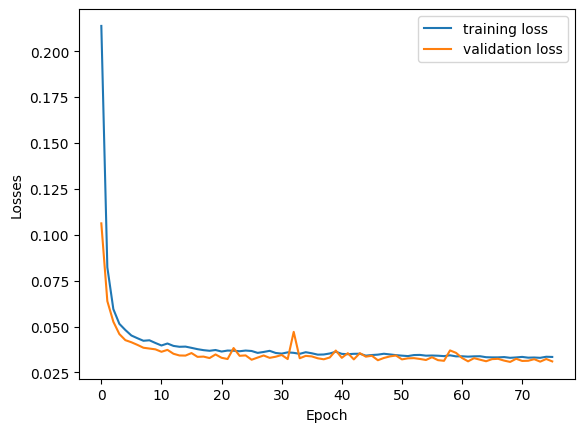

----------
Epoch 77/150
train Loss: 0.0335
val Loss: 0.0315


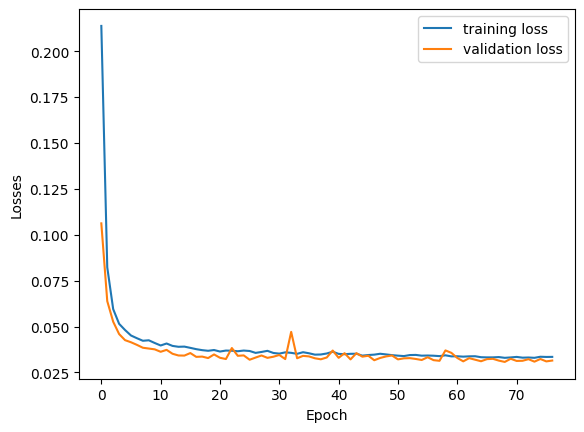

----------
Epoch 78/150
train Loss: 0.0331
val Loss: 0.0309


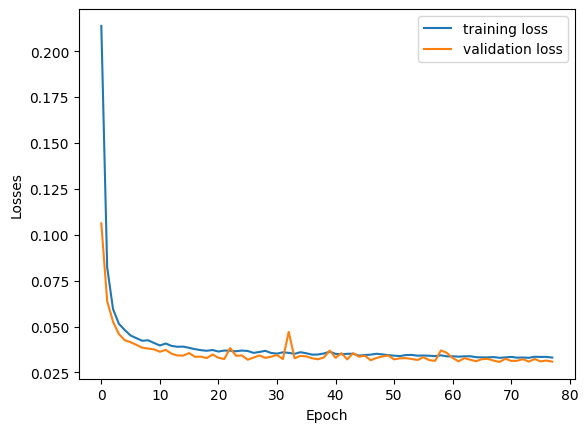

----------
Epoch 79/150
train Loss: 0.0332
val Loss: 0.0311


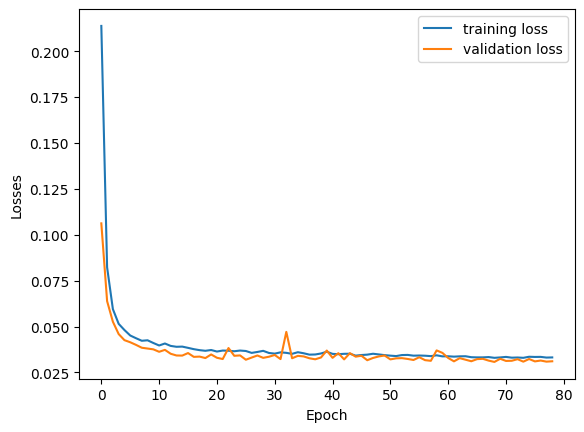

----------
Epoch 80/150
train Loss: 0.0332
val Loss: 0.0315


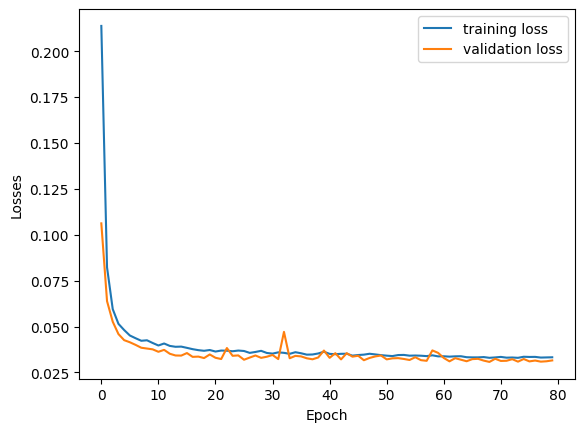

----------
Epoch 81/150
train Loss: 0.0332
val Loss: 0.0313


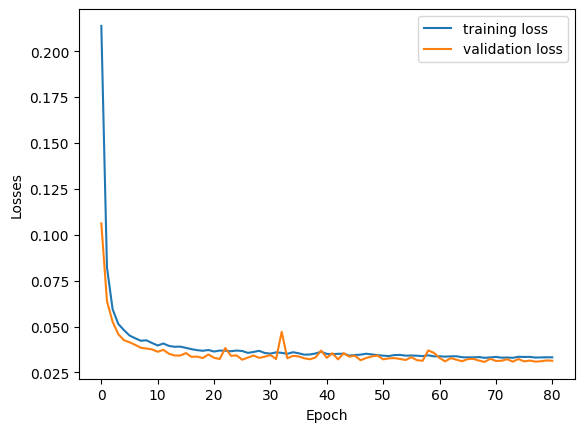

----------
Epoch 82/150
train Loss: 0.0327
val Loss: 0.0316


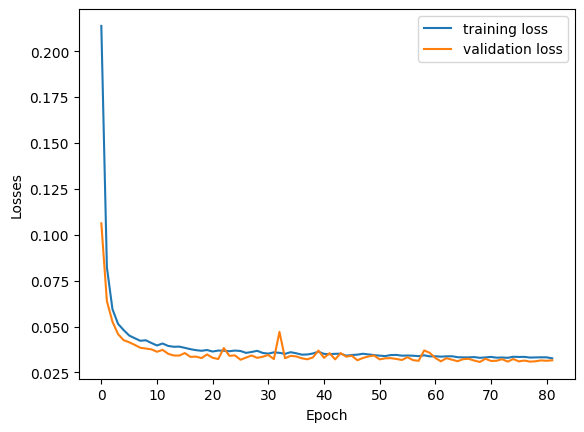

----------
Epoch 83/150
train Loss: 0.0330
val Loss: 0.0320


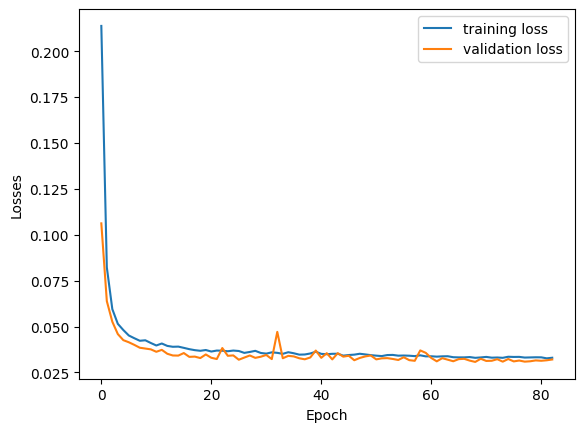

----------
Epoch 84/150
train Loss: 0.0329
val Loss: 0.0309


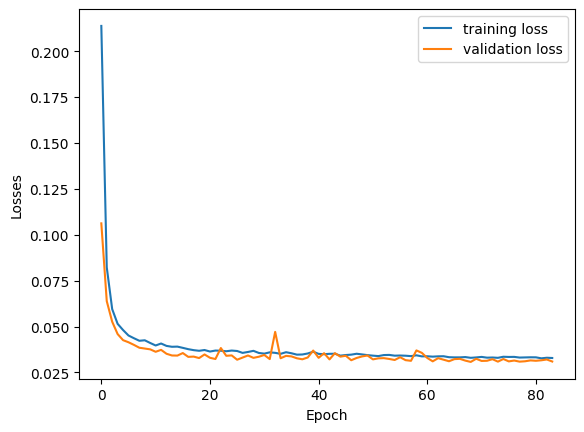

----------
Epoch 85/150
train Loss: 0.0328
val Loss: 0.0314


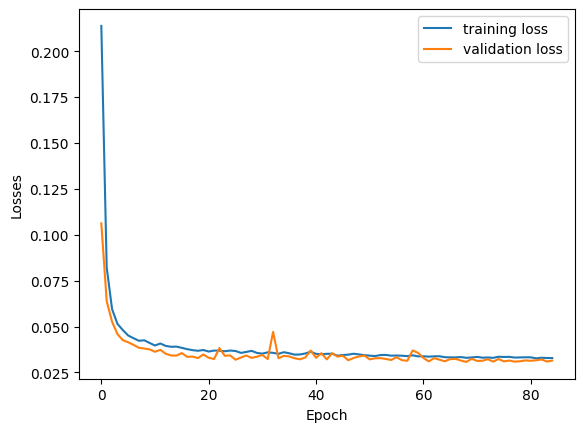

----------
Epoch 86/150
train Loss: 0.0325
val Loss: 0.0318


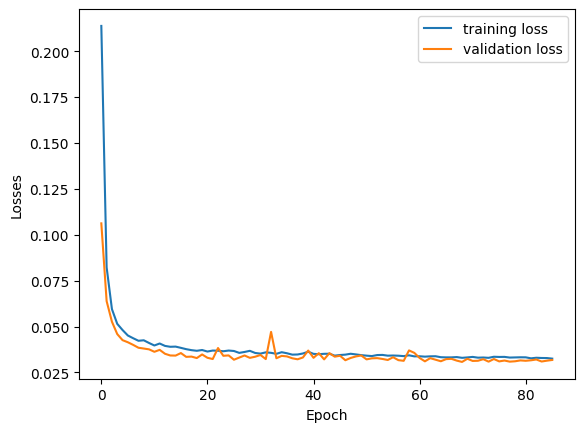

----------
Epoch 87/150
train Loss: 0.0324
val Loss: 0.0316


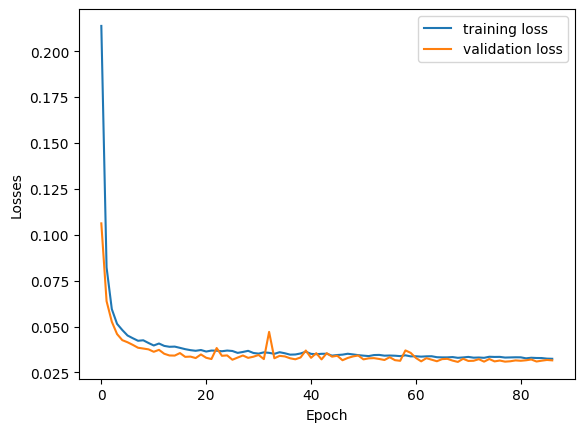

----------
Epoch 88/150
train Loss: 0.0322
val Loss: 0.0314


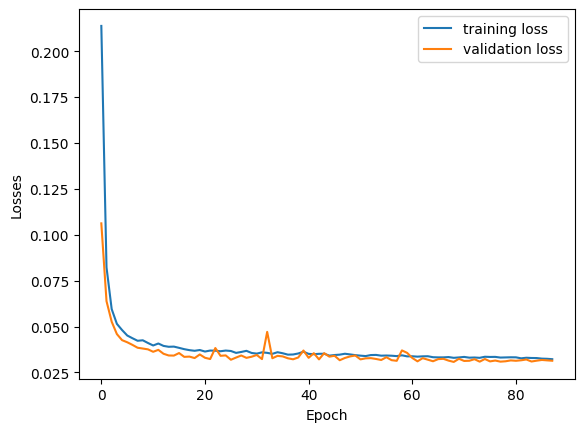

----------
Epoch 89/150
train Loss: 0.0324
val Loss: 0.0313


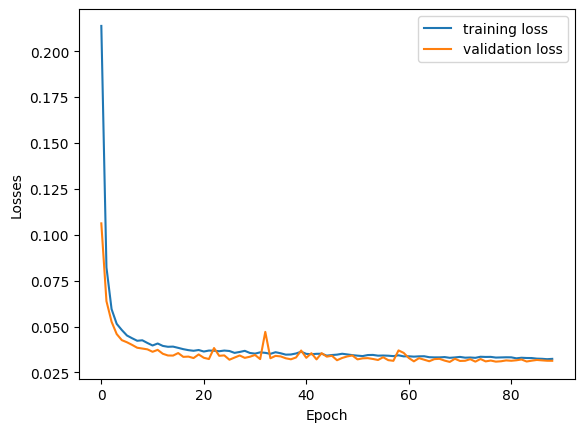

----------
Epoch 90/150
train Loss: 0.0321
val Loss: 0.0311


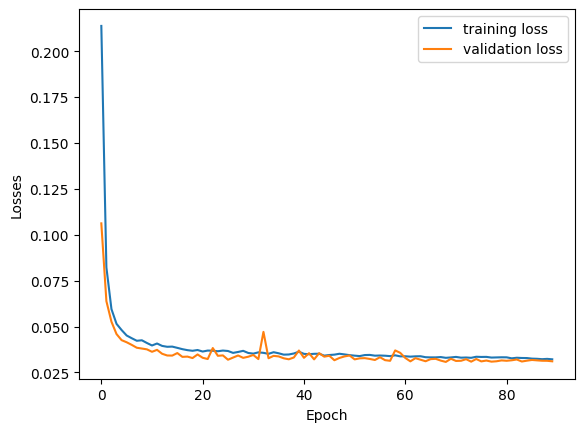

----------
Epoch 91/150
train Loss: 0.0323
val Loss: 0.0305
PASSED
Performance on test_set
Evaluation Loss: 0.0330


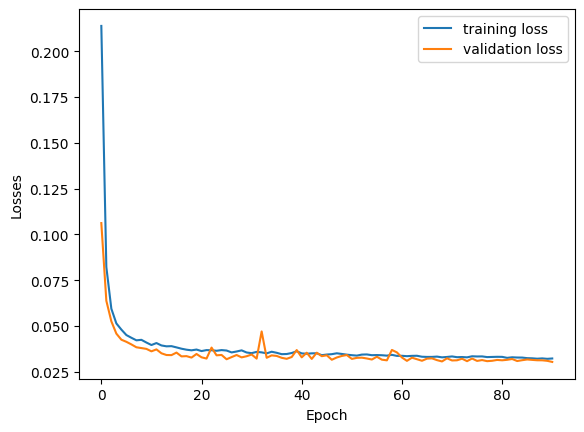

----------
Epoch 92/150
train Loss: 0.0321
val Loss: 0.0306


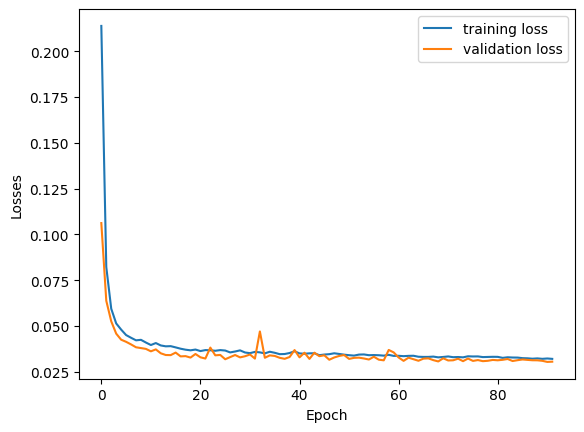

----------
Epoch 93/150
train Loss: 0.0326
val Loss: 0.0304
PASSED
Performance on test_set
Evaluation Loss: 0.0332


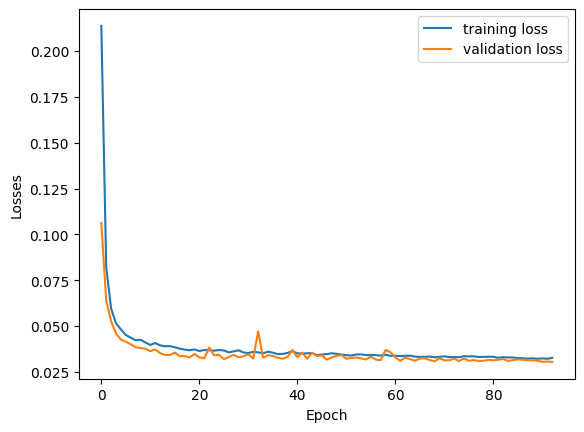

----------
Epoch 94/150
train Loss: 0.0321
val Loss: 0.0314


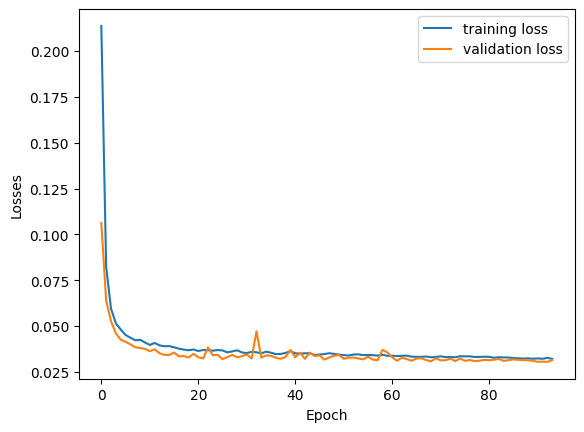

----------
Epoch 95/150
train Loss: 0.0322
val Loss: 0.0308


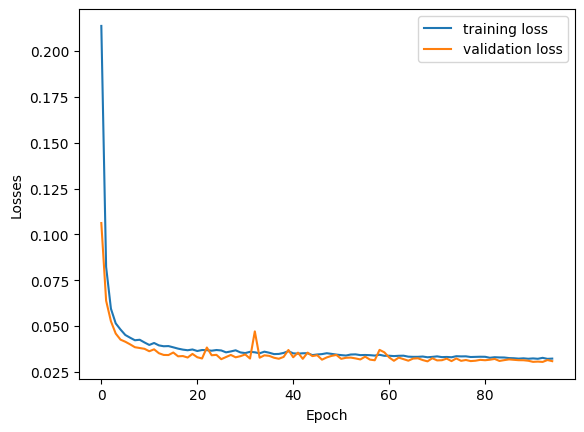

----------
Epoch 96/150
train Loss: 0.0320
val Loss: 0.0309


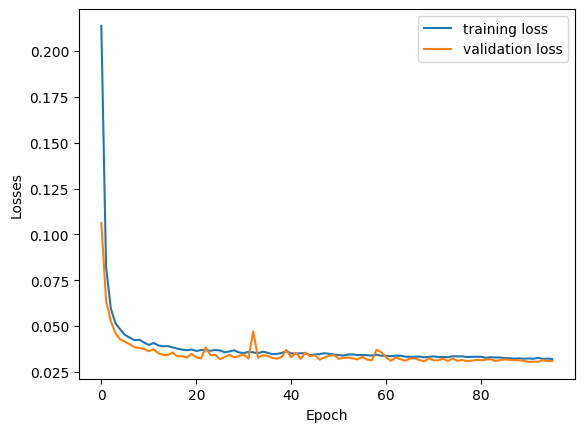

----------
Epoch 97/150
train Loss: 0.0322
val Loss: 0.0310


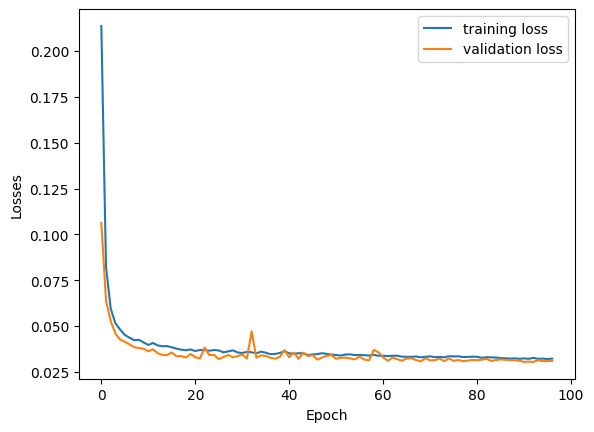

----------
Epoch 98/150
train Loss: 0.0316
val Loss: 0.0314


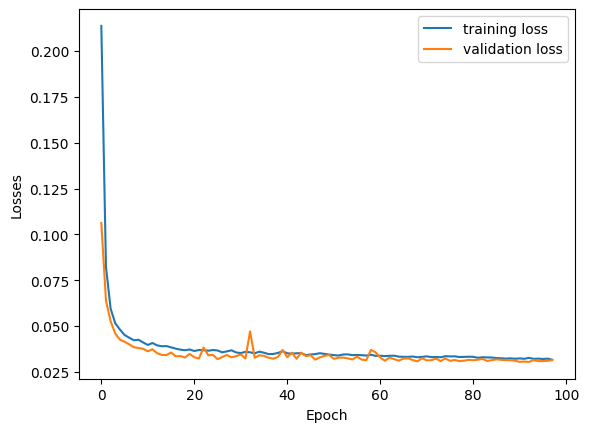

----------
Epoch 99/150
train Loss: 0.0317
val Loss: 0.0321


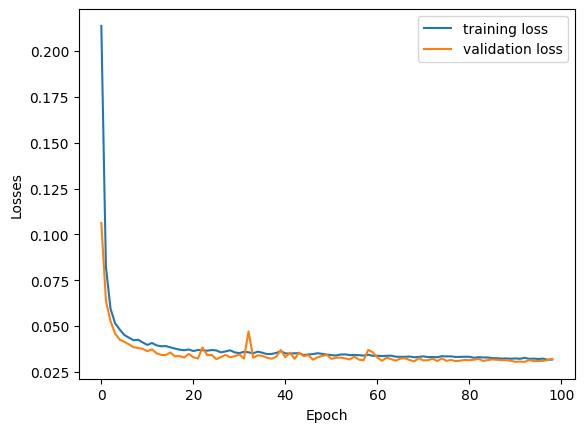

----------
Epoch 100/150
train Loss: 0.0320
val Loss: 0.0328


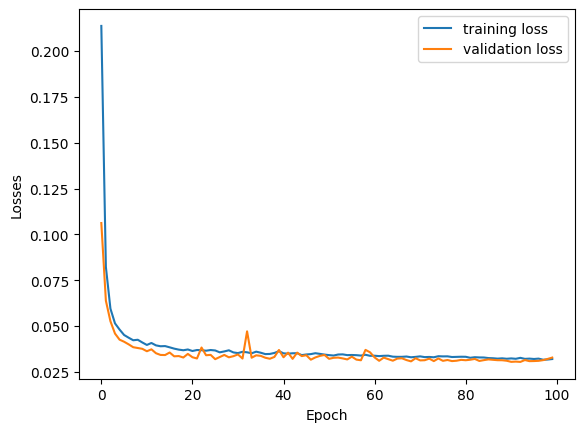

----------
Epoch 101/150
train Loss: 0.0319
val Loss: 0.0310


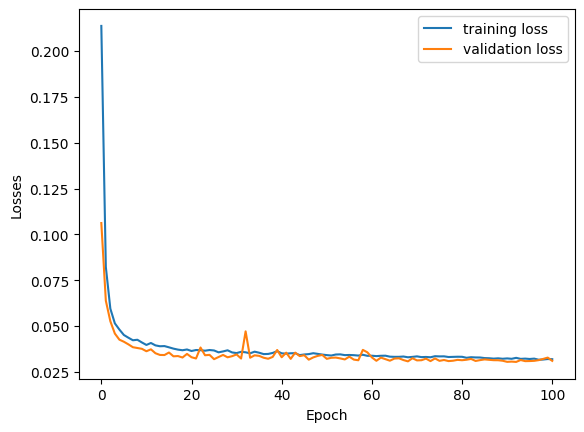

----------
Epoch 102/150
train Loss: 0.0317
val Loss: 0.0310


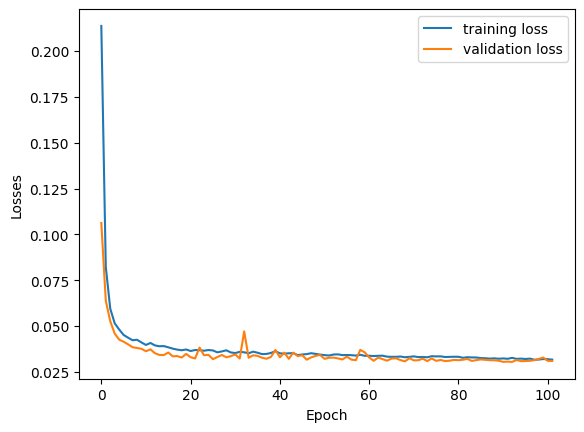

----------
Epoch 103/150
train Loss: 0.0315
val Loss: 0.0315


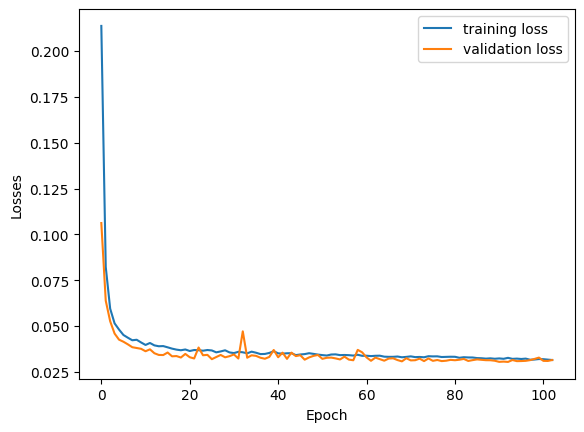

----------
Epoch 104/150
train Loss: 0.0316
val Loss: 0.0303
PASSED
Performance on test_set
Evaluation Loss: 0.0332


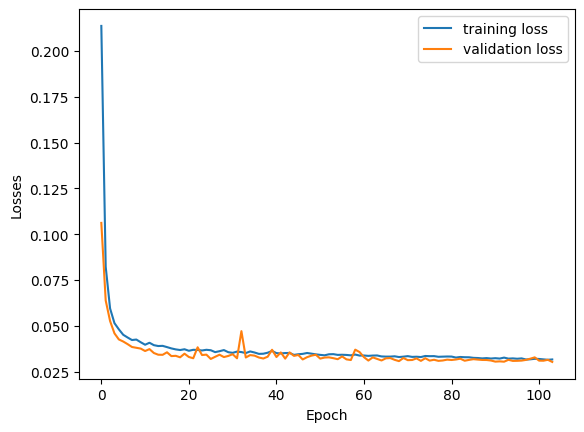

----------
Epoch 105/150
train Loss: 0.0315
val Loss: 0.0309


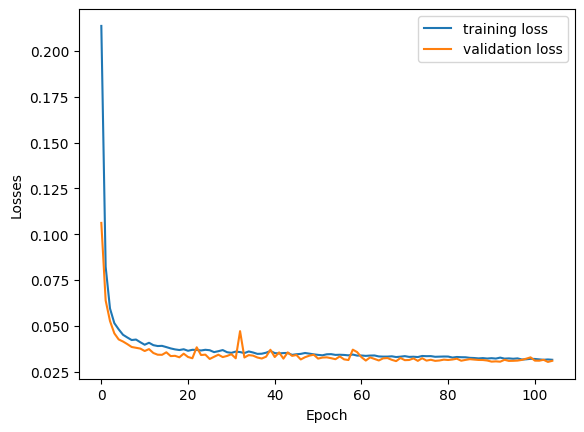

----------
Epoch 106/150
train Loss: 0.0312
val Loss: 0.0309


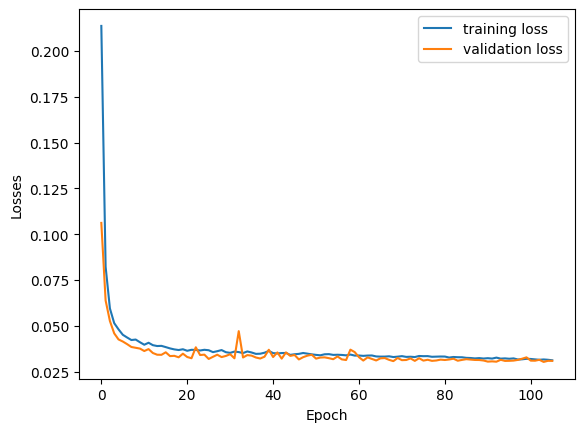

----------
Epoch 107/150
train Loss: 0.0311
val Loss: 0.0309


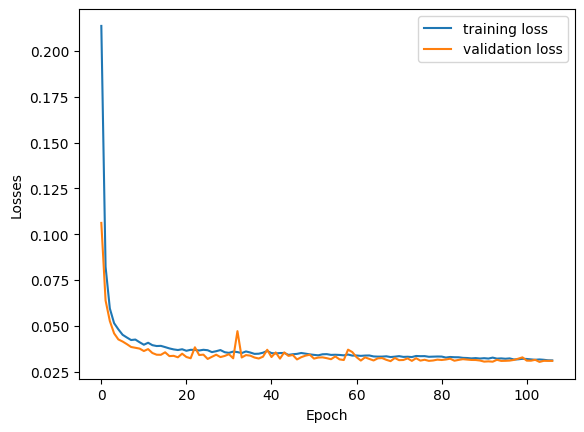

----------
Epoch 108/150
train Loss: 0.0313
val Loss: 0.0309


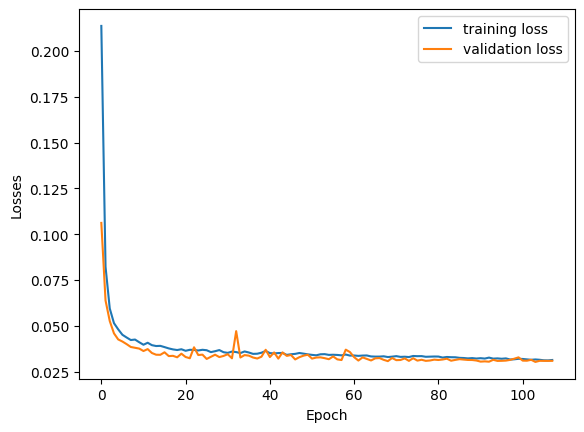

----------
Epoch 109/150
train Loss: 0.0320
val Loss: 0.0308


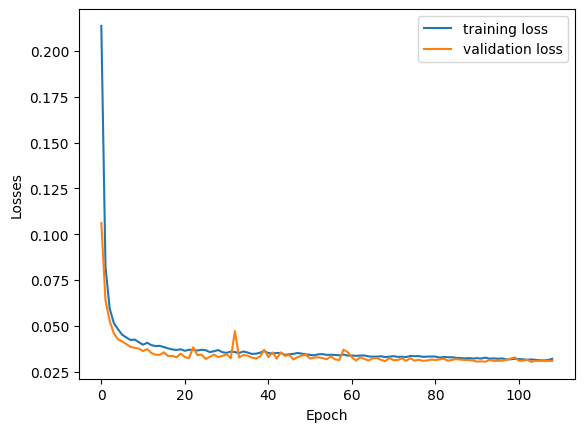

----------
Epoch 110/150
train Loss: 0.0314
val Loss: 0.0307


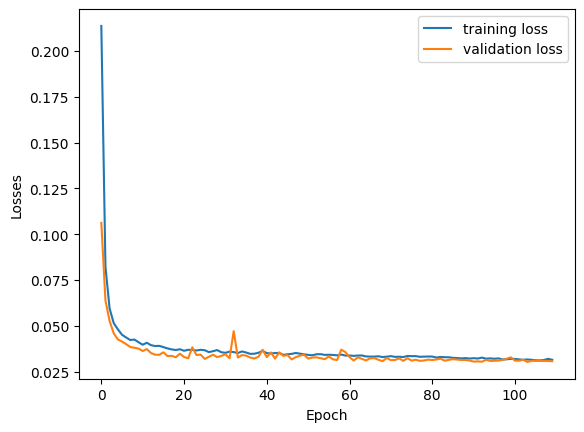

----------
Epoch 111/150
train Loss: 0.0309
val Loss: 0.0310


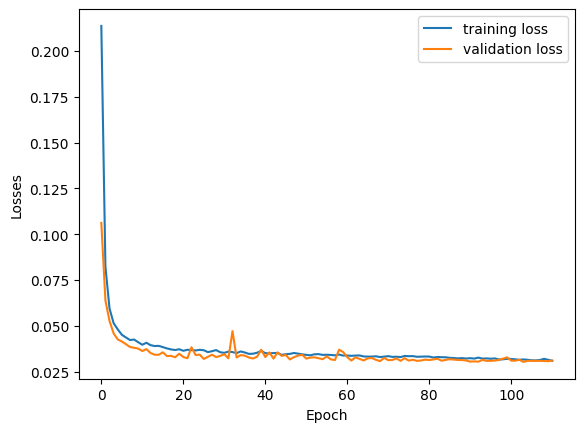

----------
Epoch 112/150
train Loss: 0.0308
val Loss: 0.0308


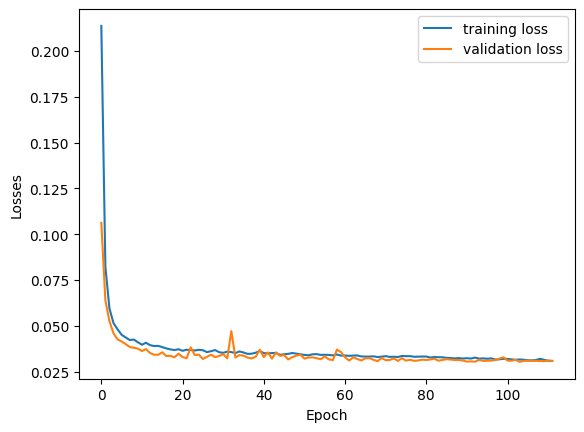

----------
Epoch 113/150
train Loss: 0.0308
val Loss: 0.0306


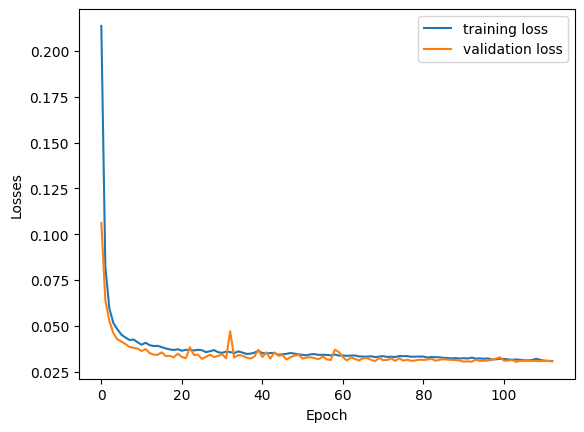

----------
Epoch 114/150
train Loss: 0.0310
val Loss: 0.0307


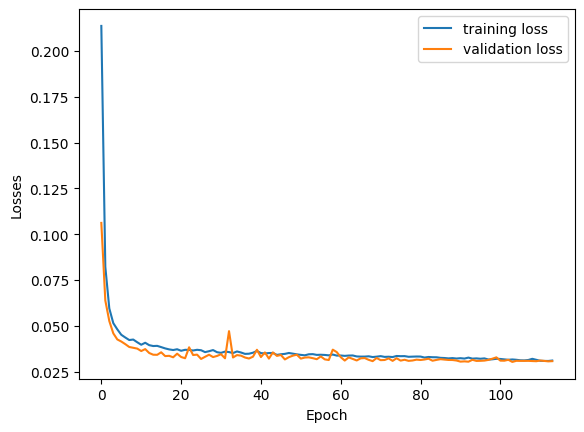

----------
Epoch 115/150
train Loss: 0.0308
val Loss: 0.0315


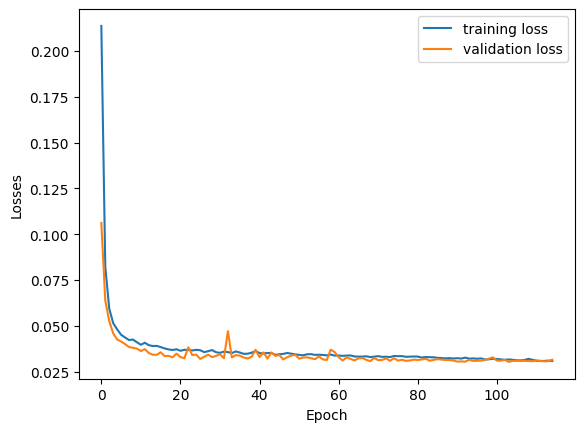

----------
Epoch 116/150
train Loss: 0.0309
val Loss: 0.0309


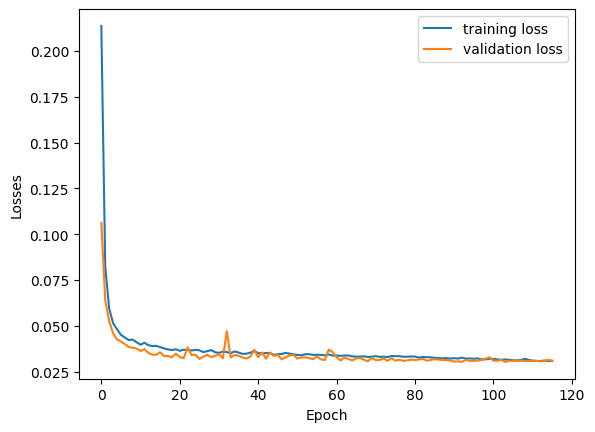

----------
Epoch 117/150
train Loss: 0.0308
val Loss: 0.0312


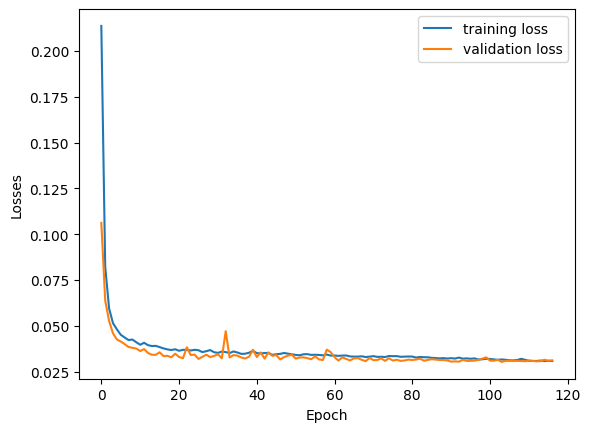

----------
Epoch 118/150
train Loss: 0.0308
val Loss: 0.0310


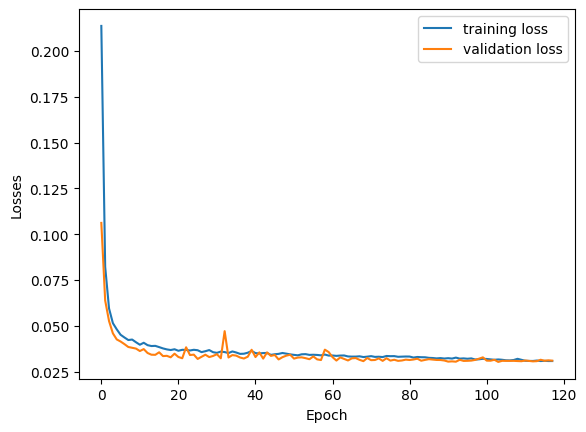

----------
Epoch 119/150
train Loss: 0.0304
val Loss: 0.0307


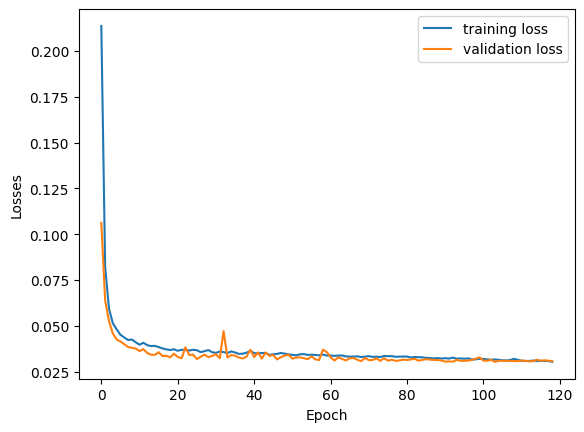

----------
Epoch 120/150
train Loss: 0.0302
val Loss: 0.0307


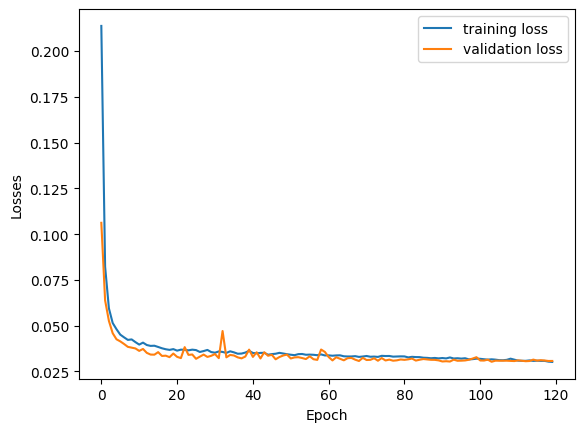

----------
Epoch 121/150
train Loss: 0.0304
val Loss: 0.0305


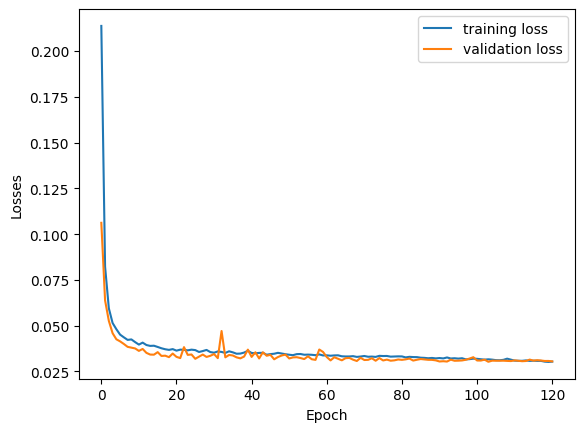

----------
Epoch 122/150
train Loss: 0.0305
val Loss: 0.0310


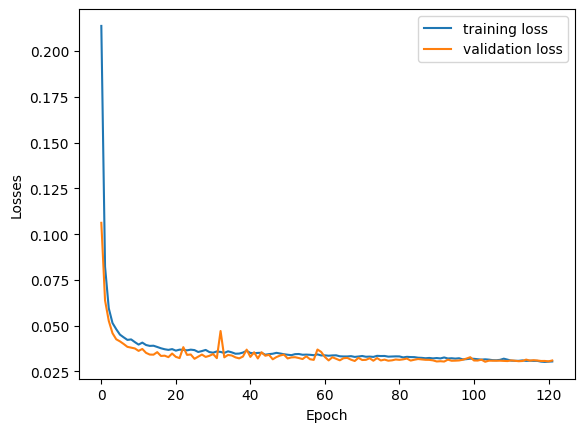

----------
Epoch 123/150
train Loss: 0.0299
val Loss: 0.0309


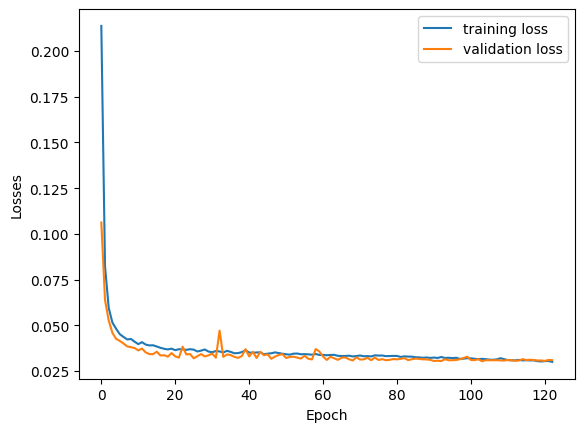

----------
Epoch 124/150
train Loss: 0.0305
val Loss: 0.0310


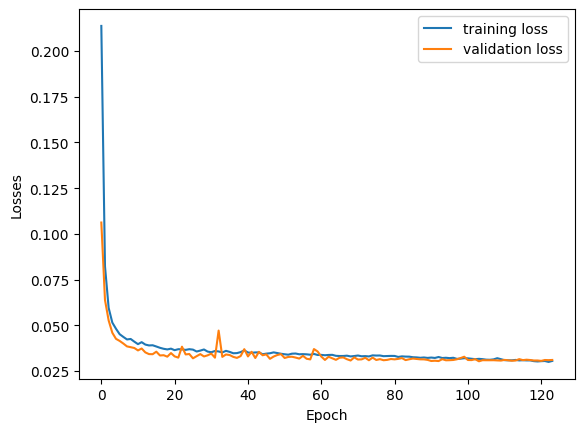

----------
Epoch 125/150
train Loss: 0.0298
val Loss: 0.0307


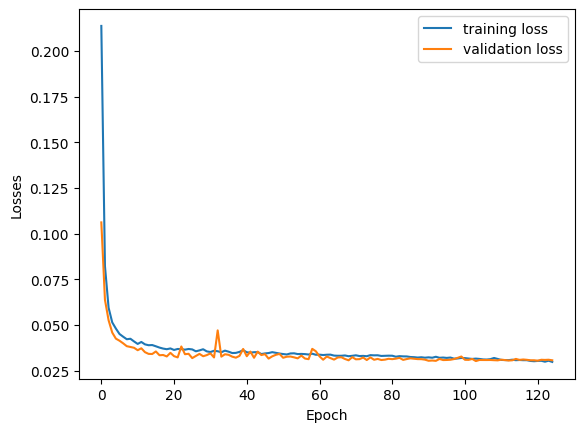

----------
Epoch 126/150
train Loss: 0.0301
val Loss: 0.0308


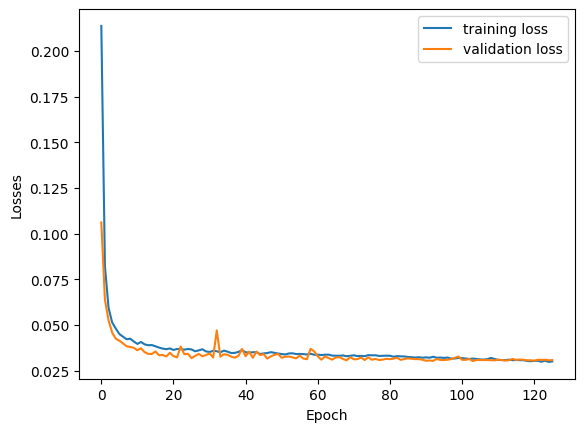

----------
Epoch 127/150
train Loss: 0.0301
val Loss: 0.0307


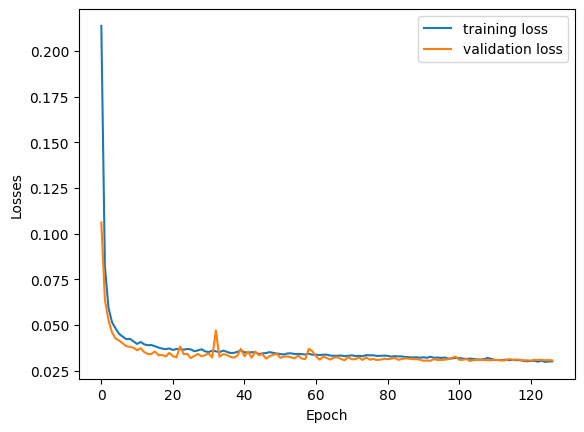

----------
Epoch 128/150
train Loss: 0.0302
val Loss: 0.0308


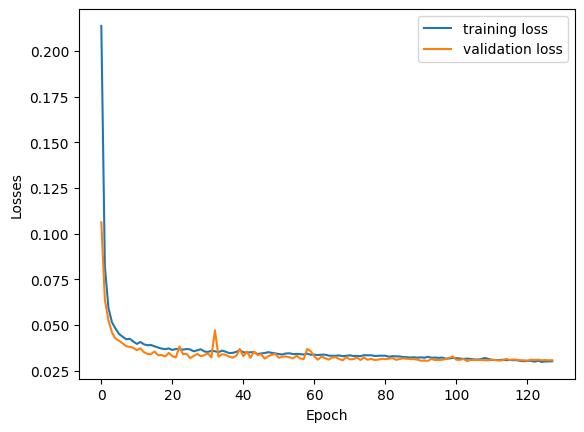

----------
Epoch 129/150
train Loss: 0.0300
val Loss: 0.0308


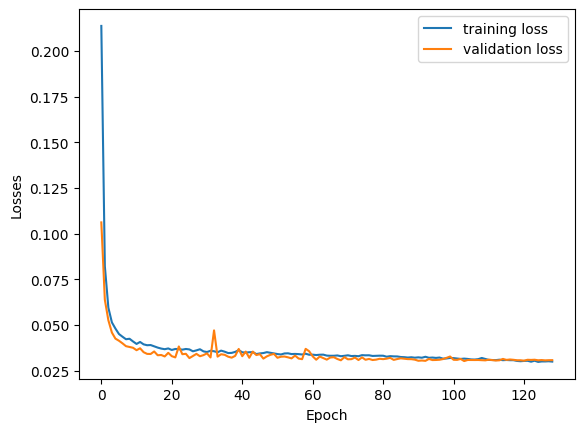

----------
Epoch 130/150
train Loss: 0.0297
val Loss: 0.0308


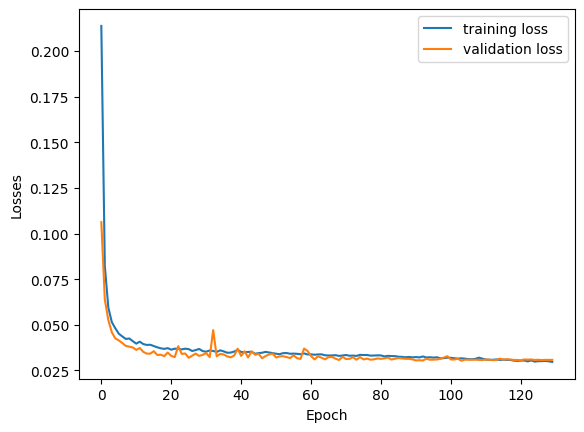

----------
Epoch 131/150
train Loss: 0.0301
val Loss: 0.0306


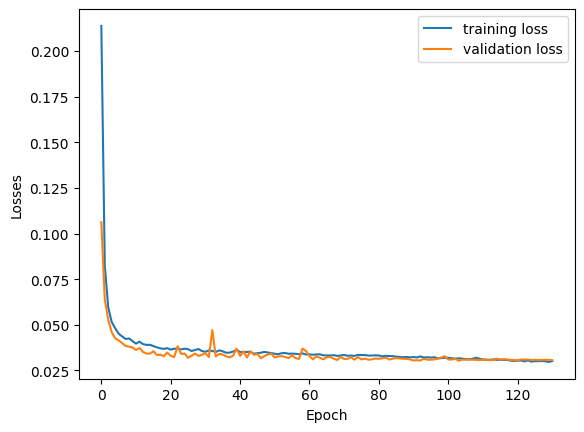

----------
Epoch 132/150
train Loss: 0.0296
val Loss: 0.0307


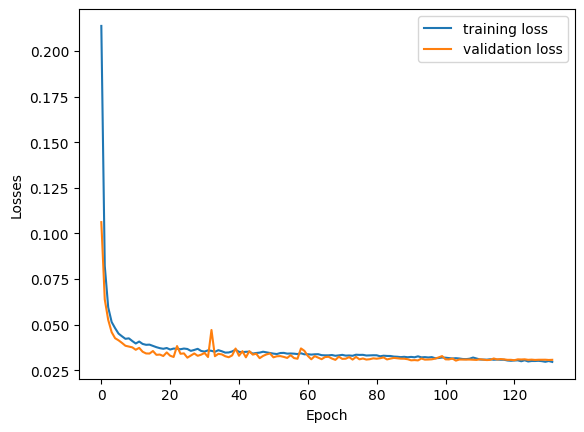

----------
Epoch 133/150
train Loss: 0.0299
val Loss: 0.0306


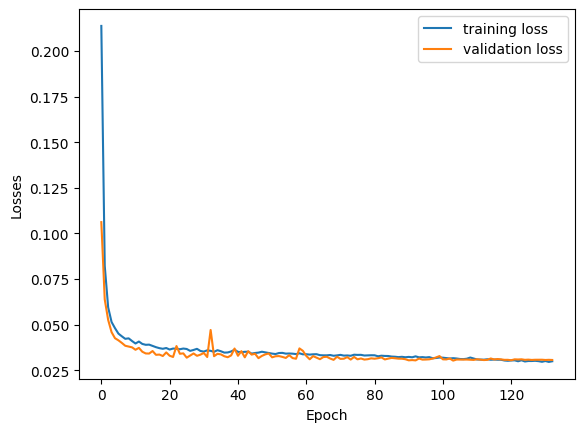

----------
Epoch 134/150
train Loss: 0.0298
val Loss: 0.0309


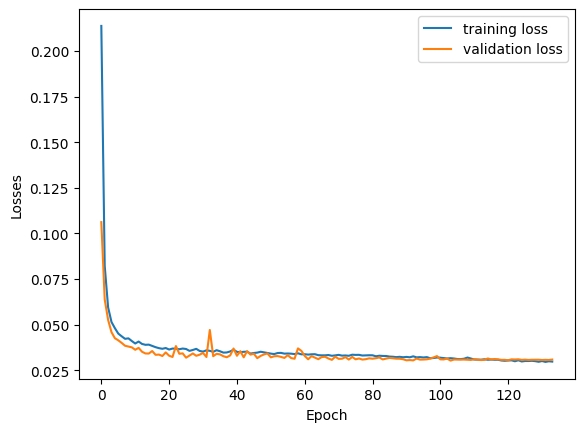

----------
Epoch 135/150
train Loss: 0.0298
val Loss: 0.0308


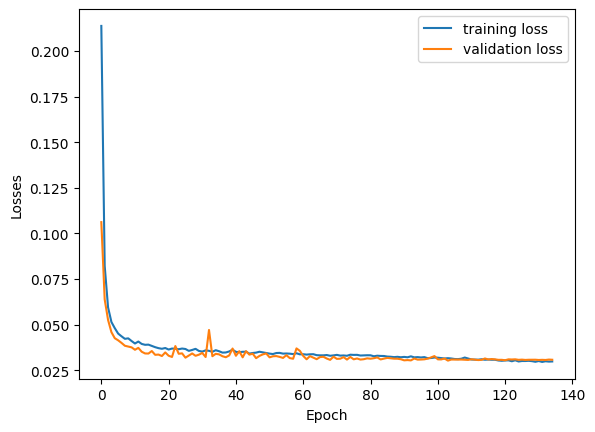

----------
Epoch 136/150
train Loss: 0.0296
val Loss: 0.0309


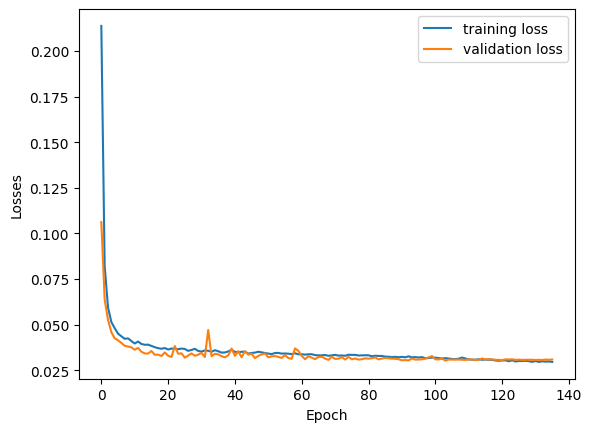

----------
Epoch 137/150
train Loss: 0.0298
val Loss: 0.0308


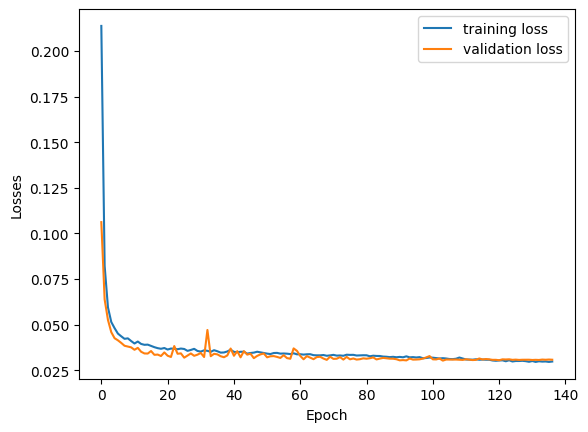

----------
Epoch 138/150
train Loss: 0.0298
val Loss: 0.0308


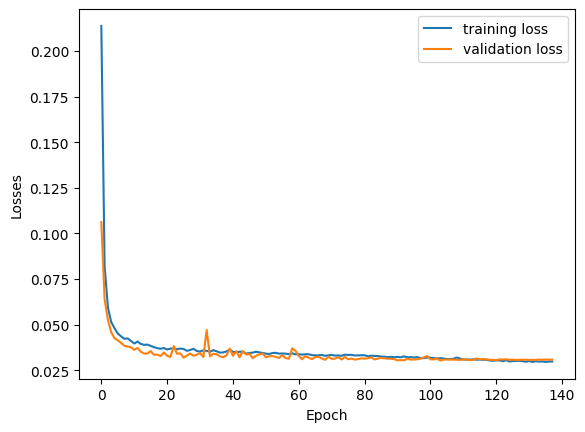

----------
Epoch 139/150
train Loss: 0.0292
val Loss: 0.0308


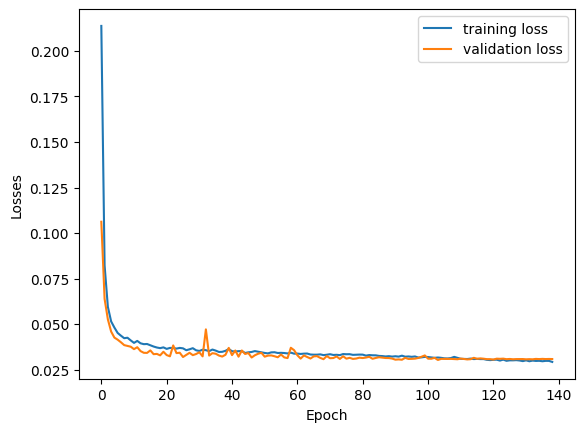

----------
Epoch 140/150
train Loss: 0.0296
val Loss: 0.0307


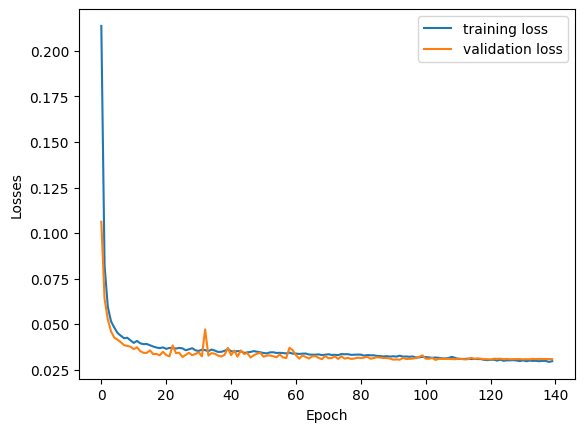

----------
Epoch 141/150
train Loss: 0.0295
val Loss: 0.0308


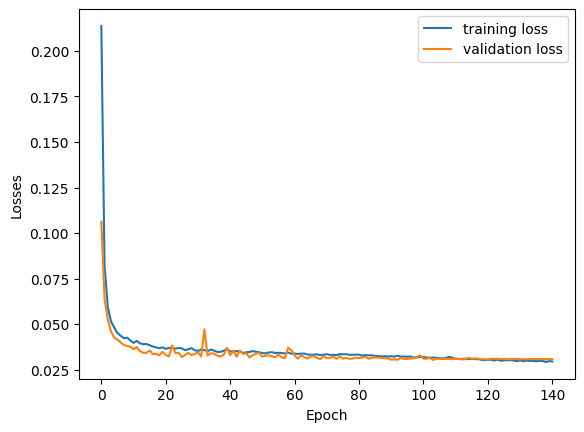

----------
Epoch 142/150
train Loss: 0.0294
val Loss: 0.0308


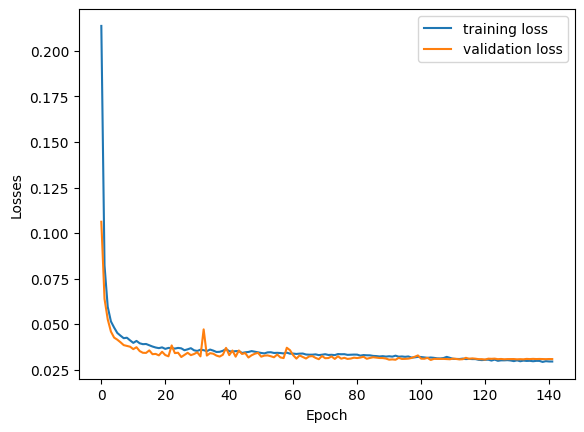

----------
Epoch 143/150
train Loss: 0.0296
val Loss: 0.0307


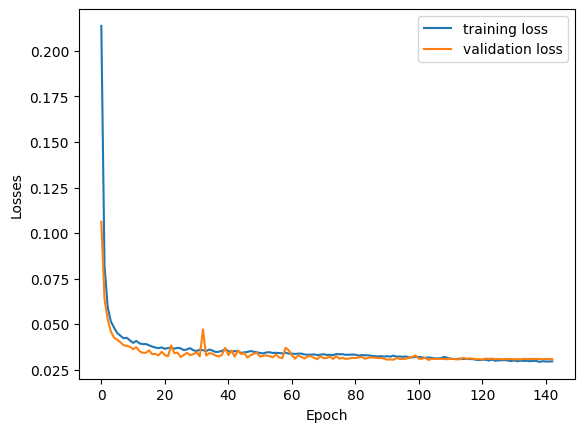

----------
Epoch 144/150
train Loss: 0.0297
val Loss: 0.0307


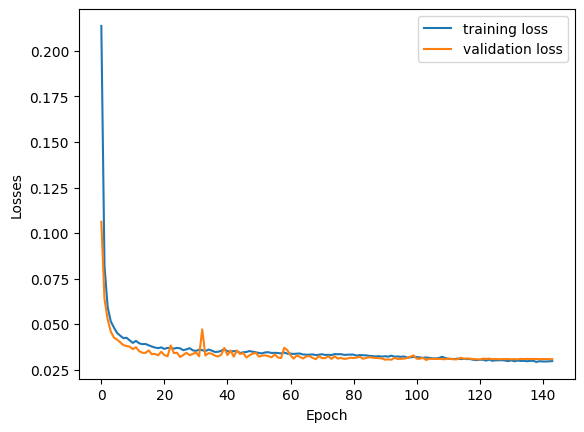

----------
Epoch 145/150
train Loss: 0.0295
val Loss: 0.0308


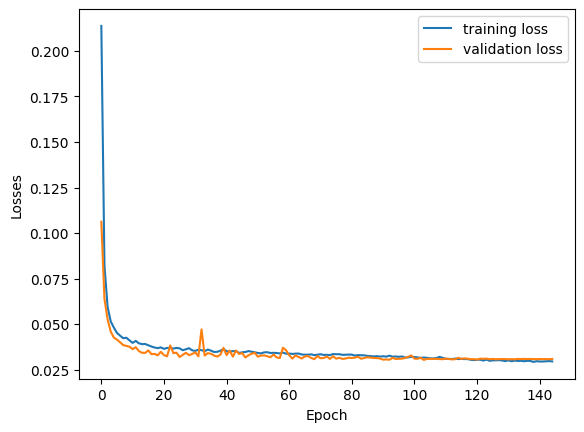

----------
Epoch 146/150
train Loss: 0.0294
val Loss: 0.0308


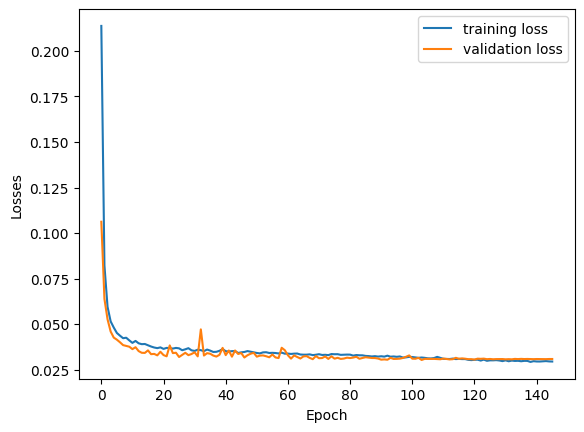

----------
Epoch 147/150
train Loss: 0.0295
val Loss: 0.0308


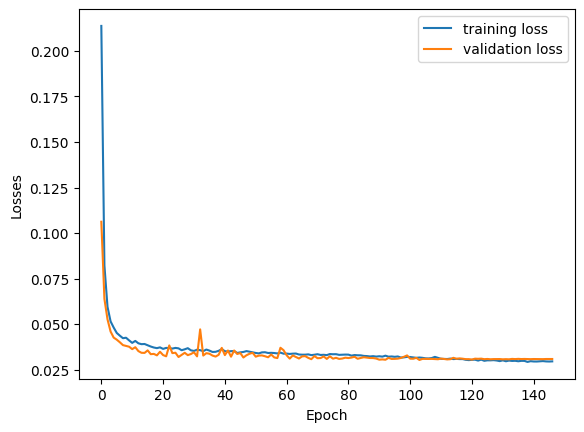

----------
Epoch 148/150
train Loss: 0.0295
val Loss: 0.0308


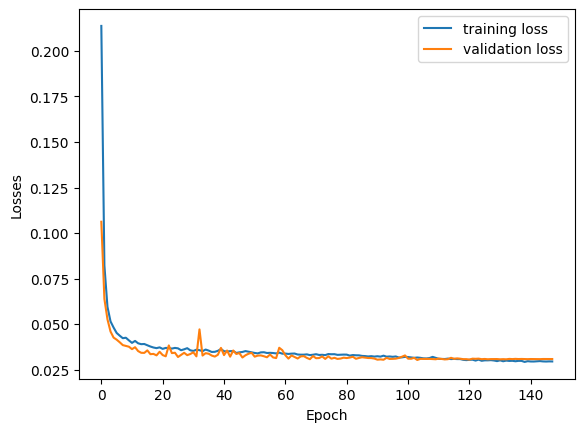

----------
Epoch 149/150
train Loss: 0.0295
val Loss: 0.0308


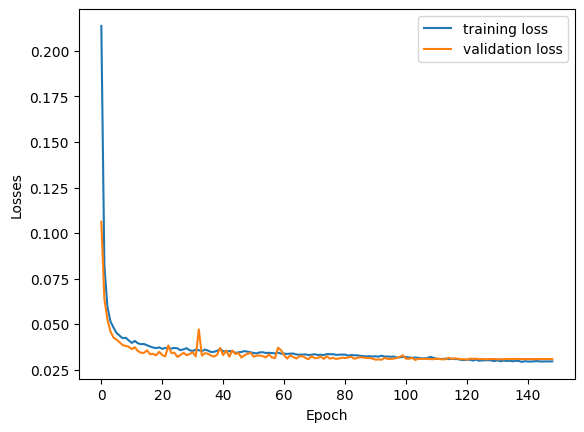

----------
Epoch 150/150
train Loss: 0.0295
val Loss: 0.0308


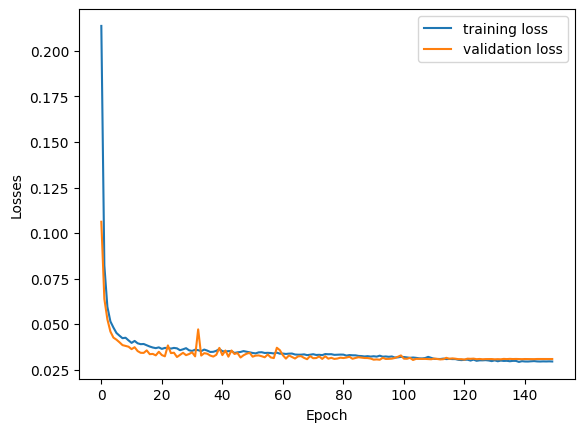

Training complete in 27m 32s
Best val Loss: 0.030290


In [343]:
model = train_model(model, criterion, l1_weight, l2_weight, optimizer, scheduler,
                       num_epochs=epochs, model_filename='NNmodel.pt')

In [211]:
# torch.save(model.state_dict(), 'something.pt')

In [344]:
preds_df = predict(model, criterion, l1_weight, l2_weight, optimizer, 'real_test')

In [345]:
preds_df.to_csv('NN_submission.csv', index=False)